In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist

from transformers import AutoImageProcessor
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
# from timesformer_pytorch import TimeSformer

import random
import threading
import glob

import numpy as np
import wandb
from torch.utils.data import DataLoader
import os
import random
import cv2
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.optim import AdamW
import segmentation_models_pytorch as smp
import numpy as np
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch
from warmup_scheduler import GradualWarmupScheduler
import PIL.Image

PIL.Image.MAX_IMAGE_PIXELS = 933120000

import utils
import models.swin as swin
import models.timesformer_hug as timesformer_hug

class TimesformerDataset(Dataset):
    def __init__(self, images, cfg, xyxys=None, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        
        self.transform = transform
        self.xyxys=xyxys
        self.video_transform = T.Compose([
            T.ConvertImageDtype(torch.float32), 
            T.Normalize(mean=[0.5], std=[0.5])
            ])
        
    def __len__(self):
        return len(self.images)

    def fourth_augment(self, image, reverse_prob=0.5):
        """
        Randomly crop 16 channels and sometimes reverse the order of channels.
        Input: image (H, W, C)
        Output: image (H, W, 16)
        
        reverse_prob: probability of reversing channels
        """

        cropping_num = 16
        num_channels = image.shape[-1]
        assert cropping_num <= num_channels, "cropping_num > number of channels"

        # Random start index
        start_idx = random.randint(0, num_channels - cropping_num)

        # Select consecutive channels
        crop_indices = np.arange(start_idx, start_idx + cropping_num)
        image_out = image[..., crop_indices]

        # # Randomly reverse channels
        # if random.random() < reverse_prob:
        #     image_out = image_out[..., ::-1]

        return image_out


    def __getitem__(self, idx):
        if self.xyxys is not None: 
            image = self.images[idx]
            label = self.labels[idx]
            xy=self.xyxys[idx]
            image = self.fourth_augment(image)
            if self.transform:
                data = self.transform(image=image, mask=label)
                image = data['image'].unsqueeze(0)
                label = data['mask']
                label=F.interpolate(label.unsqueeze(0),(self.cfg.size//16,self.cfg.size//16)).squeeze(0)

            image = image.permute(1,0,2,3)
            image = torch.stack([self.video_transform(f) for f in image])
            return image, label
        else:
            image = self.images[idx]
            label = self.labels[idx]
                        
            image = self.fourth_augment(image,0.5)
            if self.transform:
                data = self.transform(image=image, mask=label)
                image = data['image'].unsqueeze(0)
                label = data['mask']
                label=F.interpolate(label.unsqueeze(0),(self.cfg.size//16,self.cfg.size//16)).squeeze(0)
                
            image = image.permute(1,0,2,3)
            image = torch.stack([self.video_transform(f) for f in image])
            return image, label

/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
class CFG:
    # ============== comp exp name =============
    current_dir = './'
    segment_path = './train_scrolls/'
    
    start_idx = 20
    valid_chans = 16
    in_chans = 16
    
    size = 64
    tile_size = 64
    stride = tile_size // 1
    
    train_batch_size =  1# 32
    valid_batch_size = 5
    lr = 1e-4
    num_workers = 8
    # ============== model cfg =============
    scheduler = 'cosine'#, 'linear'
    epochs = 16
    warmup_factor = 10
    
    # Change the size of fragments
    frags_ratio1 = ['frag','re']
    frags_ratio2 = ['202','s4','left']
    ratio1 = 2
    ratio2 = 1
    
    # ============== fold =============
    segments = ['rect1','20231210132040'] 
    valid_id = 'rect1'#20231215151901'
    
    # ============== fixed =============
    min_lr = 1e-7
    weight_decay = 1e-6
    max_grad_norm = 100
    num_workers = 8
    seed = 0
    
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    exp_name = 'pretraining_all'

    outputs_path = f'./outputs/{comp_name}/{exp_name}/'
    model_dir = outputs_path + \
        f'{comp_name}-models/'
        
    # ============== augmentation =============
    train_aug_list = [
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        # A.CoarseDropout(max_holes=2, max_width=int(size * 0.2), max_height=int(size * 0.2), 
        #                 mask_fill_value=0, p=0.5),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [

        ToTensorV2(transpose_mask=True),  
    ]
    
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)
    return aug   


# End any existing run (if still active)
if wandb.run is not None:
    wandb.finish()
        
utils.cfg_init(CFG)
torch.set_float32_matmul_precision('medium')

fragment_id = CFG.valid_id
run_slug=f'SWIN_{CFG.segments}_valid={CFG.valid_id}_size={CFG.size}_lr={CFG.lr}_in_chans={CFG.in_chans}'
valid_mask_gt = cv2.imread(f"{CFG.segment_path}{fragment_id}/{fragment_id}_inklabels.png", 0)

if any(sub in fragment_id for sub in CFG.frags_ratio1):
    scale = 1 / CFG.ratio1
    new_w = int(valid_mask_gt.shape[1] * scale)
    new_h = int(valid_mask_gt.shape[0] * scale)
    valid_mask_gt = cv2.resize(valid_mask_gt, (new_w, new_h), interpolation=cv2.INTER_AREA)

elif any(sub in fragment_id for sub in CFG.frags_ratio2):
    scale = 1 / CFG.ratio2
    new_w = int(valid_mask_gt.shape[1] * scale)
    new_h = int(valid_mask_gt.shape[0] * scale)
    valid_mask_gt = cv2.resize(valid_mask_gt, (new_w, new_h), interpolation=cv2.INTER_AREA)
pred_shape=valid_mask_gt.shape

train_images, train_masks, valid_images, valid_masks, valid_xyxys = utils.get_train_valid_dataset(CFG)
train_images = train_images[10:11]
train_masks = train_masks[10:11]

print('train_images',train_images[0].shape)
print("Length of train images:", len(train_images))

valid_xyxys = np.stack(valid_xyxys)
train_dataset = TimesformerDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = TimesformerDataset(
    valid_images, CFG, xyxys=valid_xyxys, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                            batch_size=CFG.train_batch_size,
                            shuffle=True,
                            num_workers=0, pin_memory=True, drop_last=True,
                            )
valid_loader = DataLoader(valid_dataset,
                            batch_size=CFG.valid_batch_size,
                            shuffle=False,
                            num_workers=0, pin_memory=True, drop_last=True)

print(f"Train loader length: {len(train_loader)}")
print(f"Valid loader length: {len(valid_loader)}")

reading rect1
valid
20


 19%|█▉        | 3/16 [00:00<00:00, 29.90it/s]

100%|██████████| 16/16 [00:00<00:00, 28.01it/s]


 Shape of rect1 segment: (512, 768, 16)
reading 20231210132040


100%|██████████| 16/16 [00:08<00:00,  1.78it/s]


 Shape of 20231210132040 segment: (8832, 12160, 16)
train_images (64, 64, 16)
Length of train images: 1
Train loader length: 1
Valid loader length: 15


In [3]:
for x,y in train_loader:
    print(x.max())
    print(x.min())
    break

tensor(0.5529)
tensor(-0.7412)


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_reconstruction(original, reconstructed, sample_idx=0, num_frames=4):
    """
    Visualize original and reconstructed video frames side by side.

    Args:
        original: tensor (B, T, C, H, W) original video batch
        reconstructed: tensor (B, T, C, H, W) reconstructed video batch
        sample_idx: int, index in batch to visualize
        num_frames: int, number of frames to display
    """
    orig = original[sample_idx]     # (T, C, H, W)
    recon = reconstructed[sample_idx]  # (T, C, H, W)
    # print(recon.shape)

    # If grayscale, squeeze channel dim
    if orig.shape[1] == 1:
        orig = orig.squeeze(1)
        recon = recon.squeeze(1)

    # Clamp and convert to numpy
    orig = orig.cpu().numpy()
    recon = recon.cpu().detach().numpy()

    fig, axes = plt.subplots(2, num_frames, figsize=(3 * num_frames, 6))

    for i in range(num_frames):
        # Original frame
        ax = axes[0, i]
        ax.imshow(orig[i], cmap='gray')
        ax.set_title(f"Original Frame {i}")
        ax.axis('off')

        # Reconstructed frame
        ax = axes[1, i]
        ax.imshow(recon[i], cmap='gray')
        ax.set_title(f"Reconstructed Frame {i}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Timesformer

/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: St

Total patches: 1024
Unmasked_patches: 256
Actual patches used: 256/1024 : 0.25
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

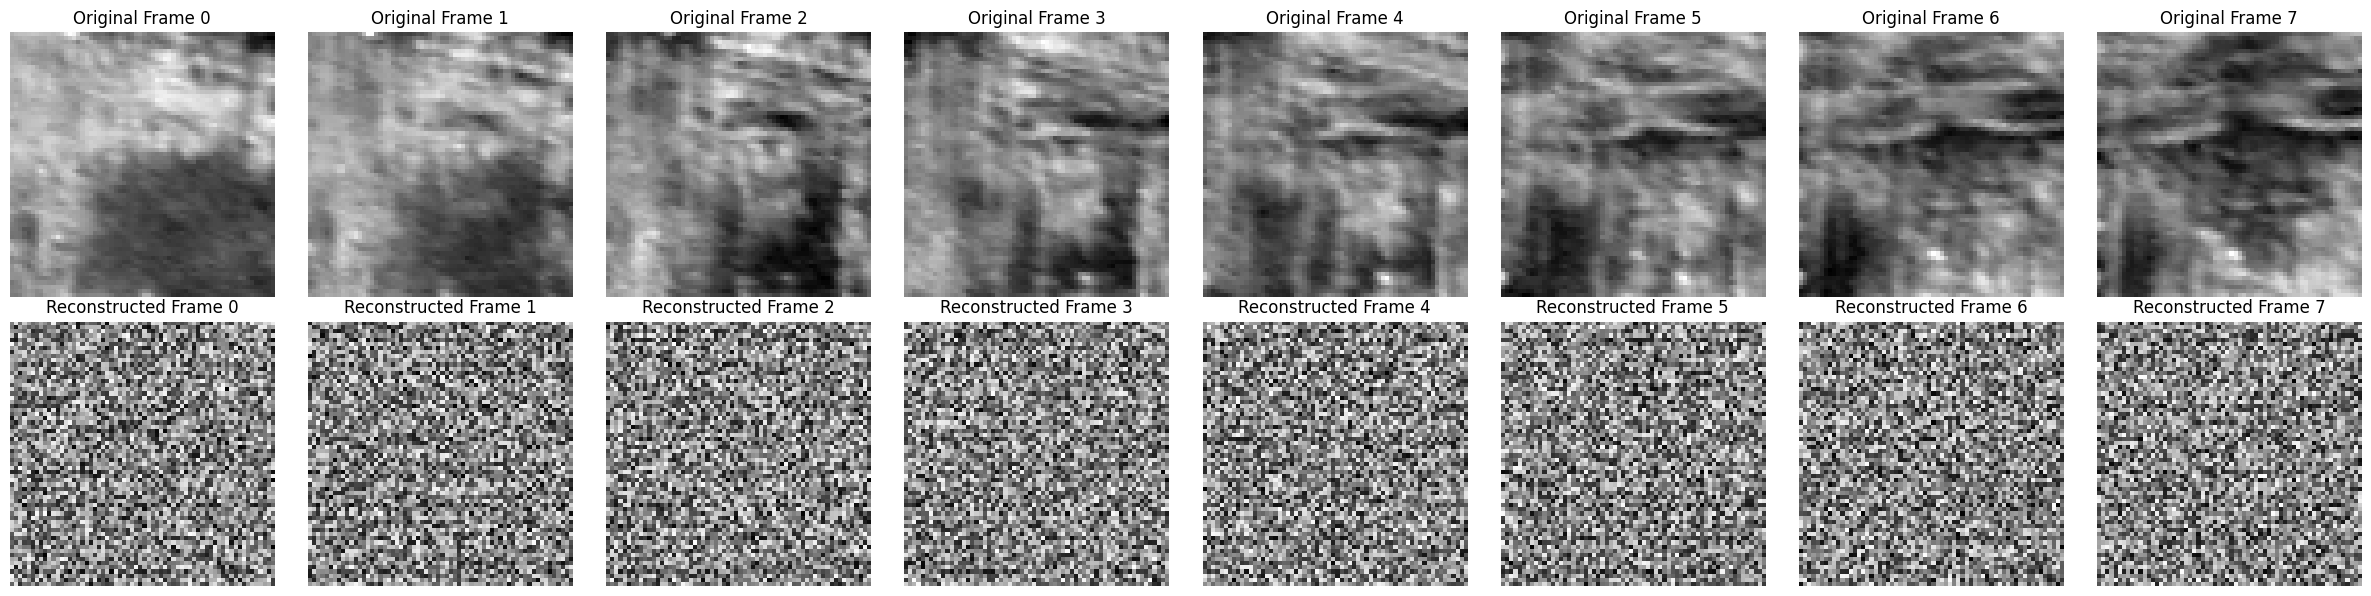

/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=11, train_loss=0.177, lr=9.99e-5]       

/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:990: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s, v_num=11, train_loss=0.106, lr=9.9e-5] 

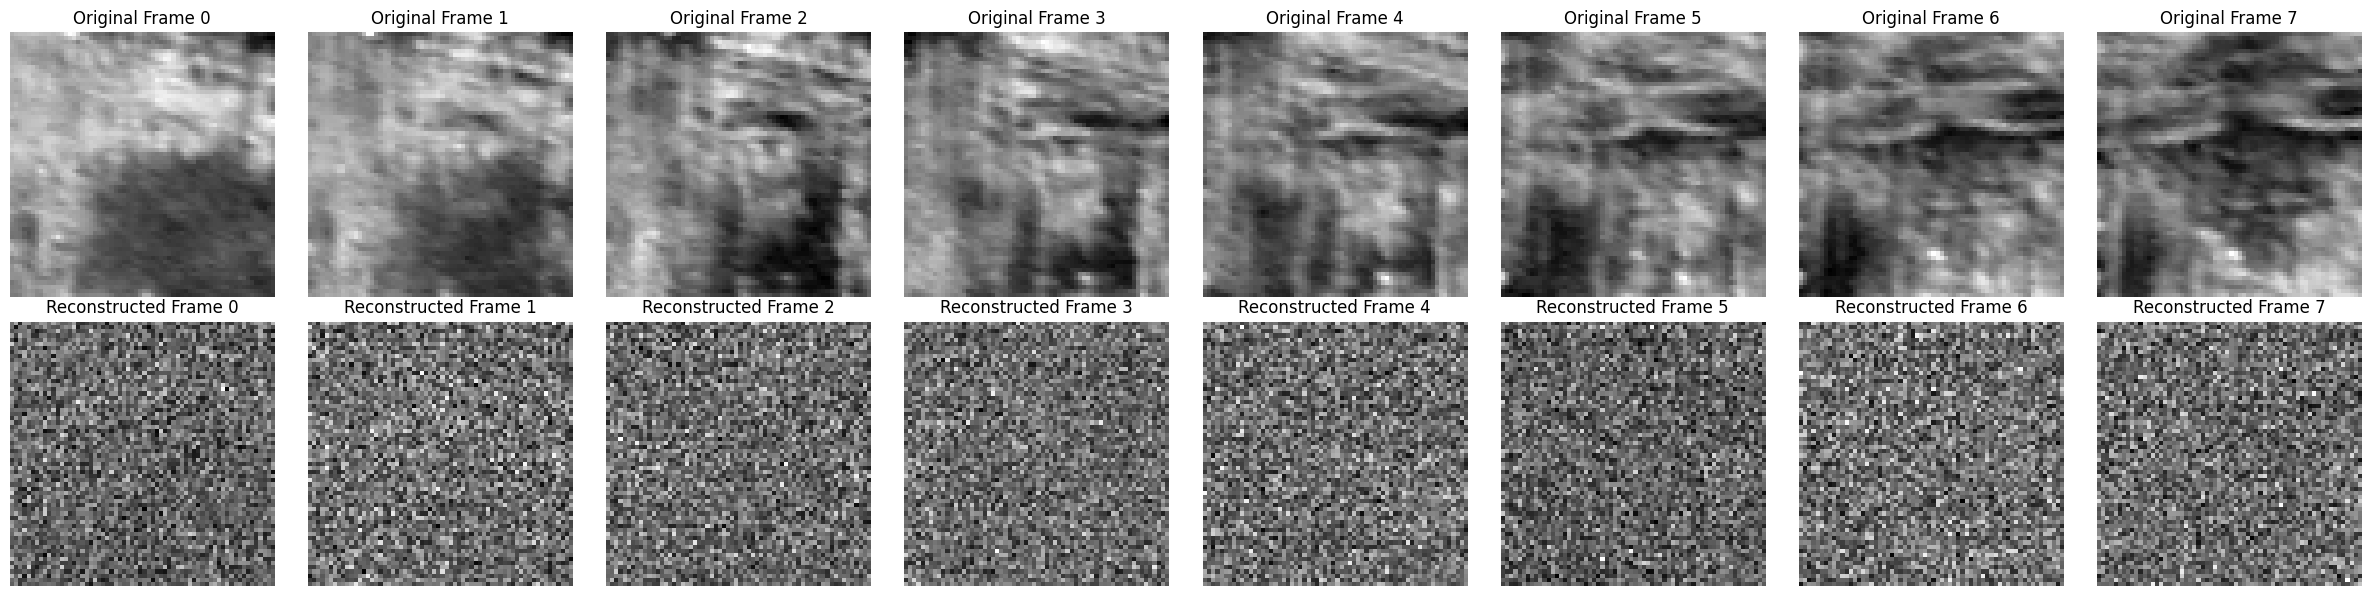

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s, v_num=11, train_loss=0.0534, lr=9.34e-5, val_loss=0.0932]

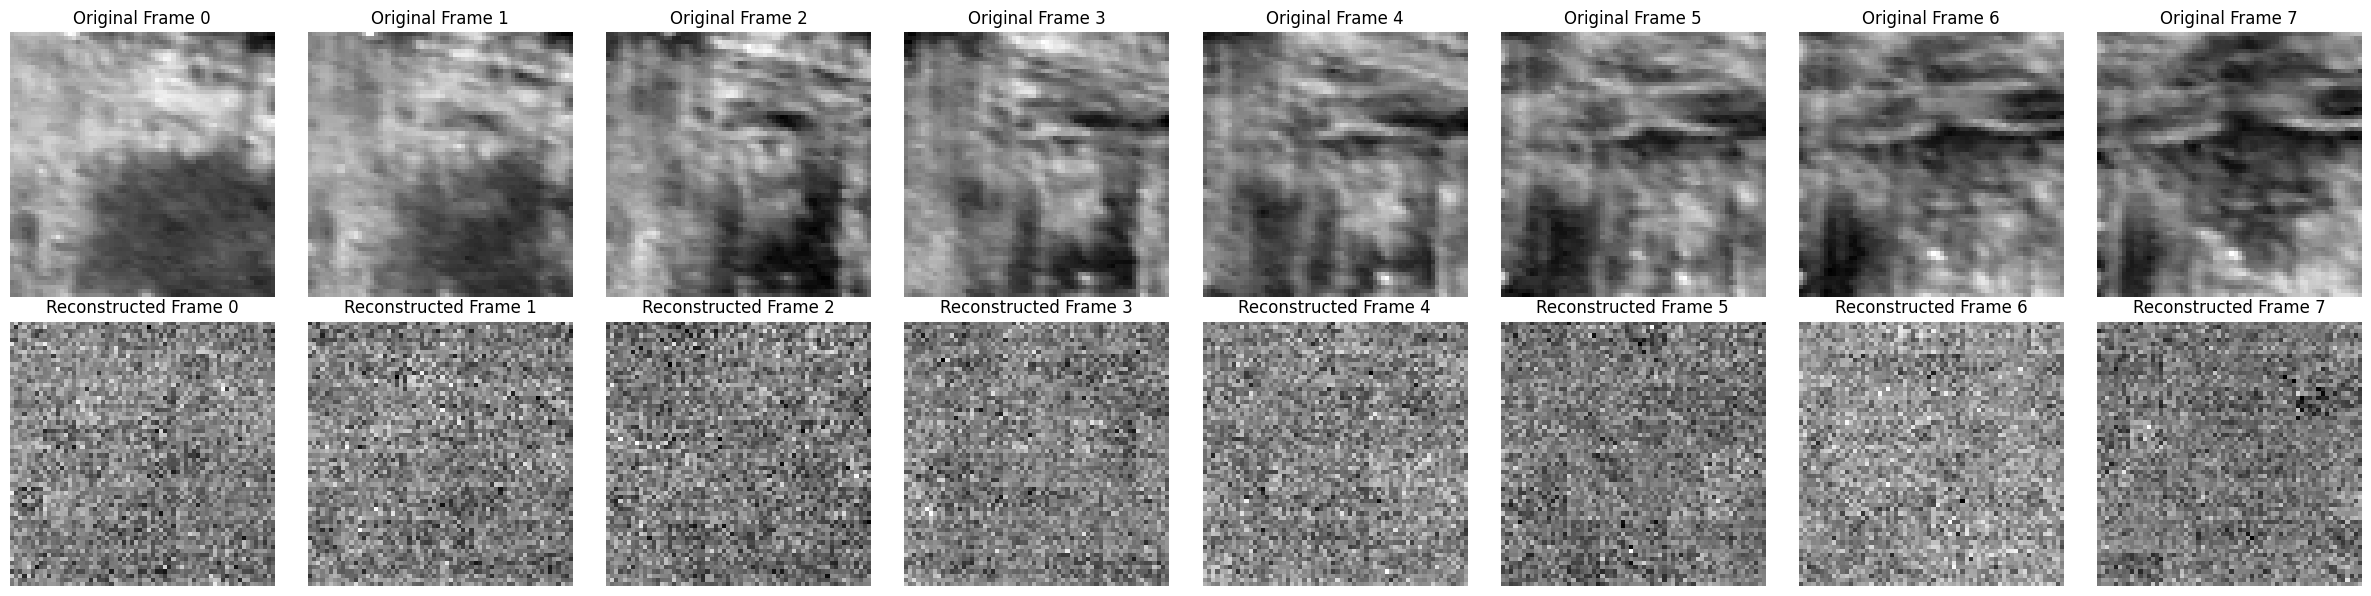

Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 22.87it/s, v_num=11, train_loss=0.0468, lr=8.37e-5, val_loss=0.0392]

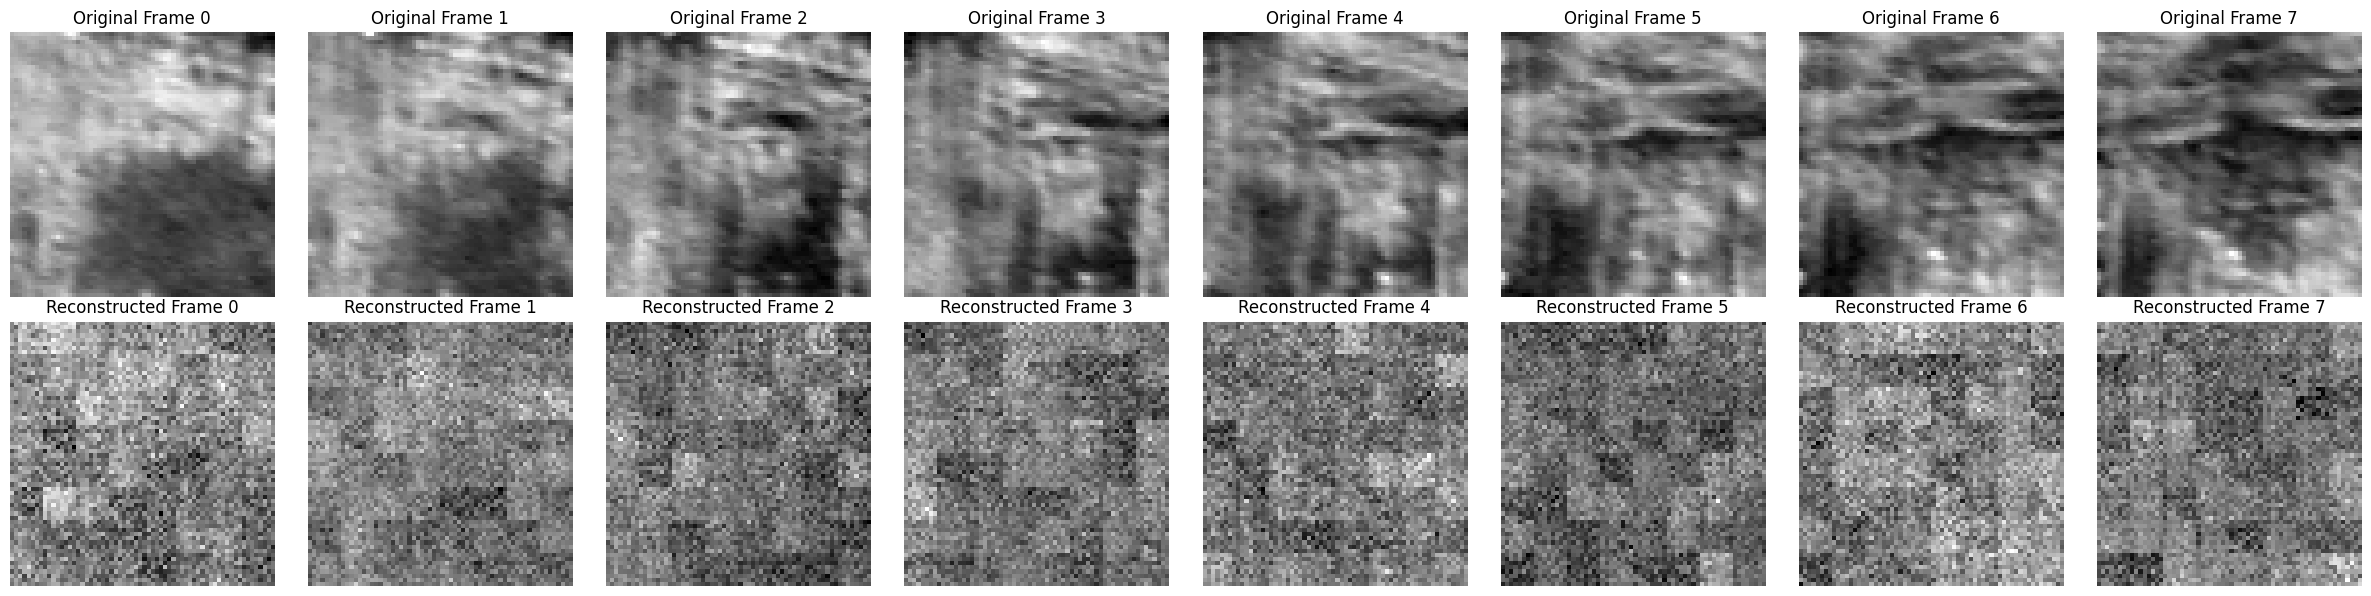

Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 22.53it/s, v_num=11, train_loss=0.0393, lr=7.06e-5, val_loss=0.0351]

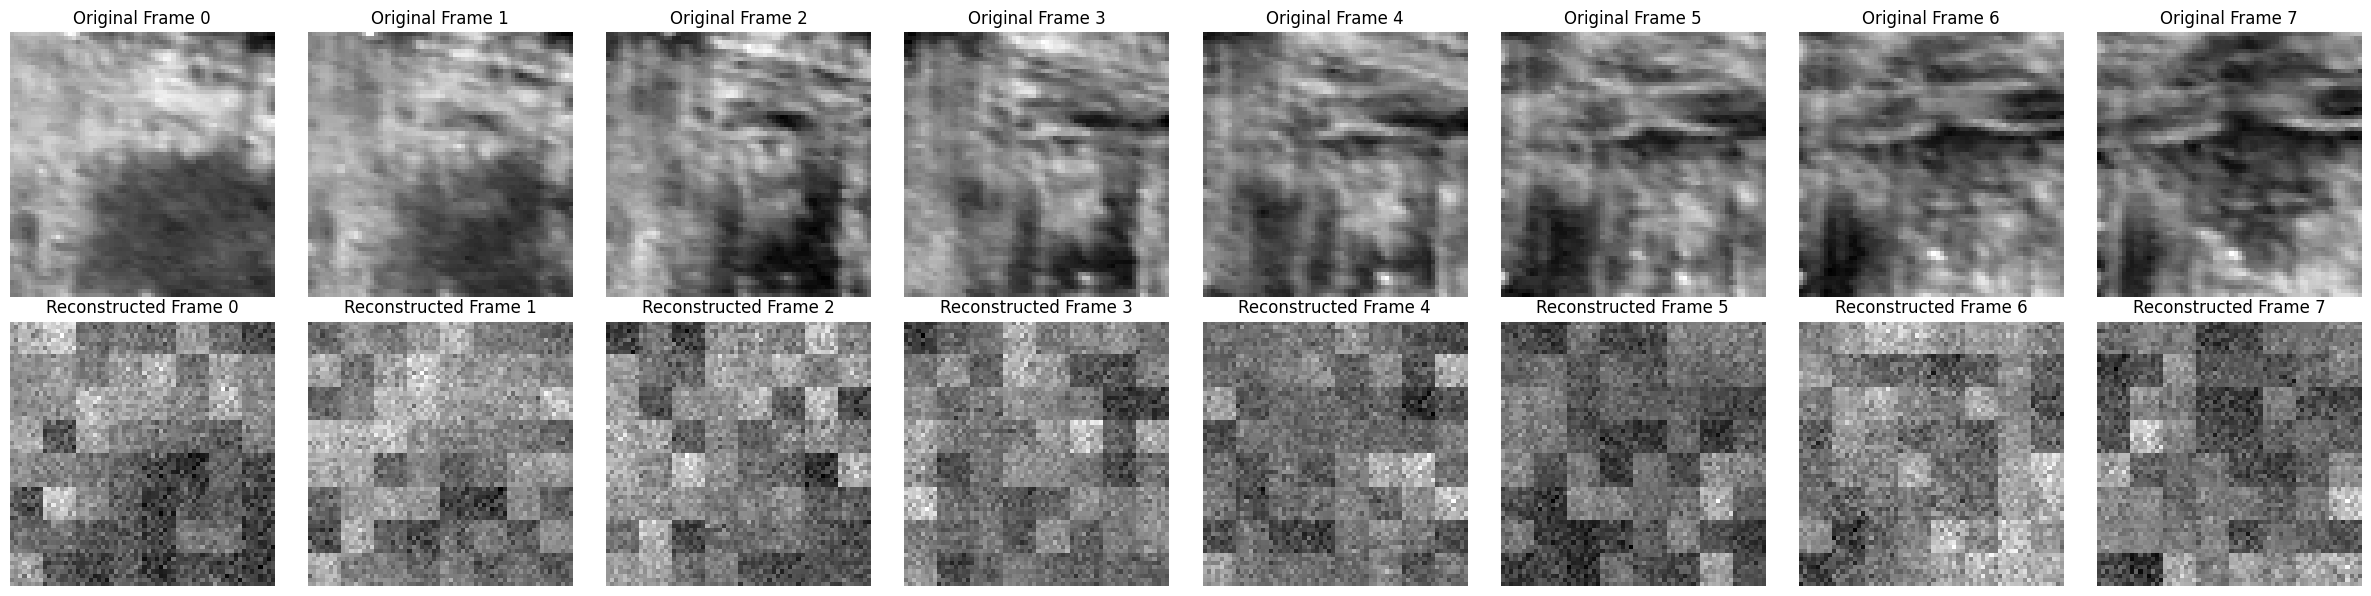

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.94it/s, v_num=11, train_loss=0.034, lr=5.55e-5, val_loss=0.0303] 

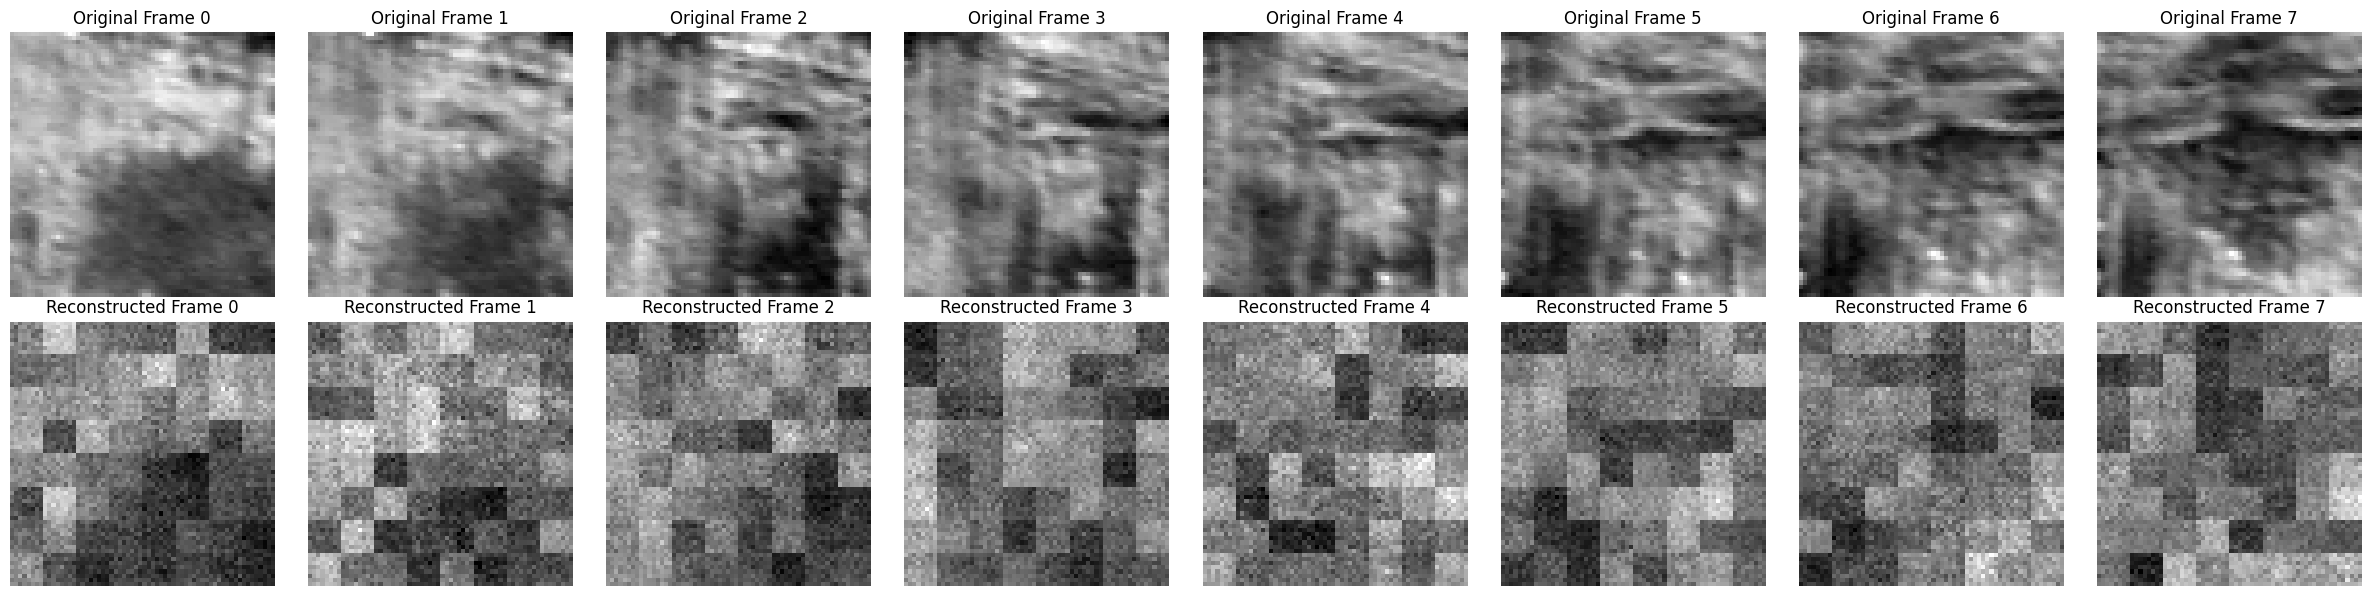

Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 23.44it/s, v_num=11, train_loss=0.0309, lr=3.99e-5, val_loss=0.026]

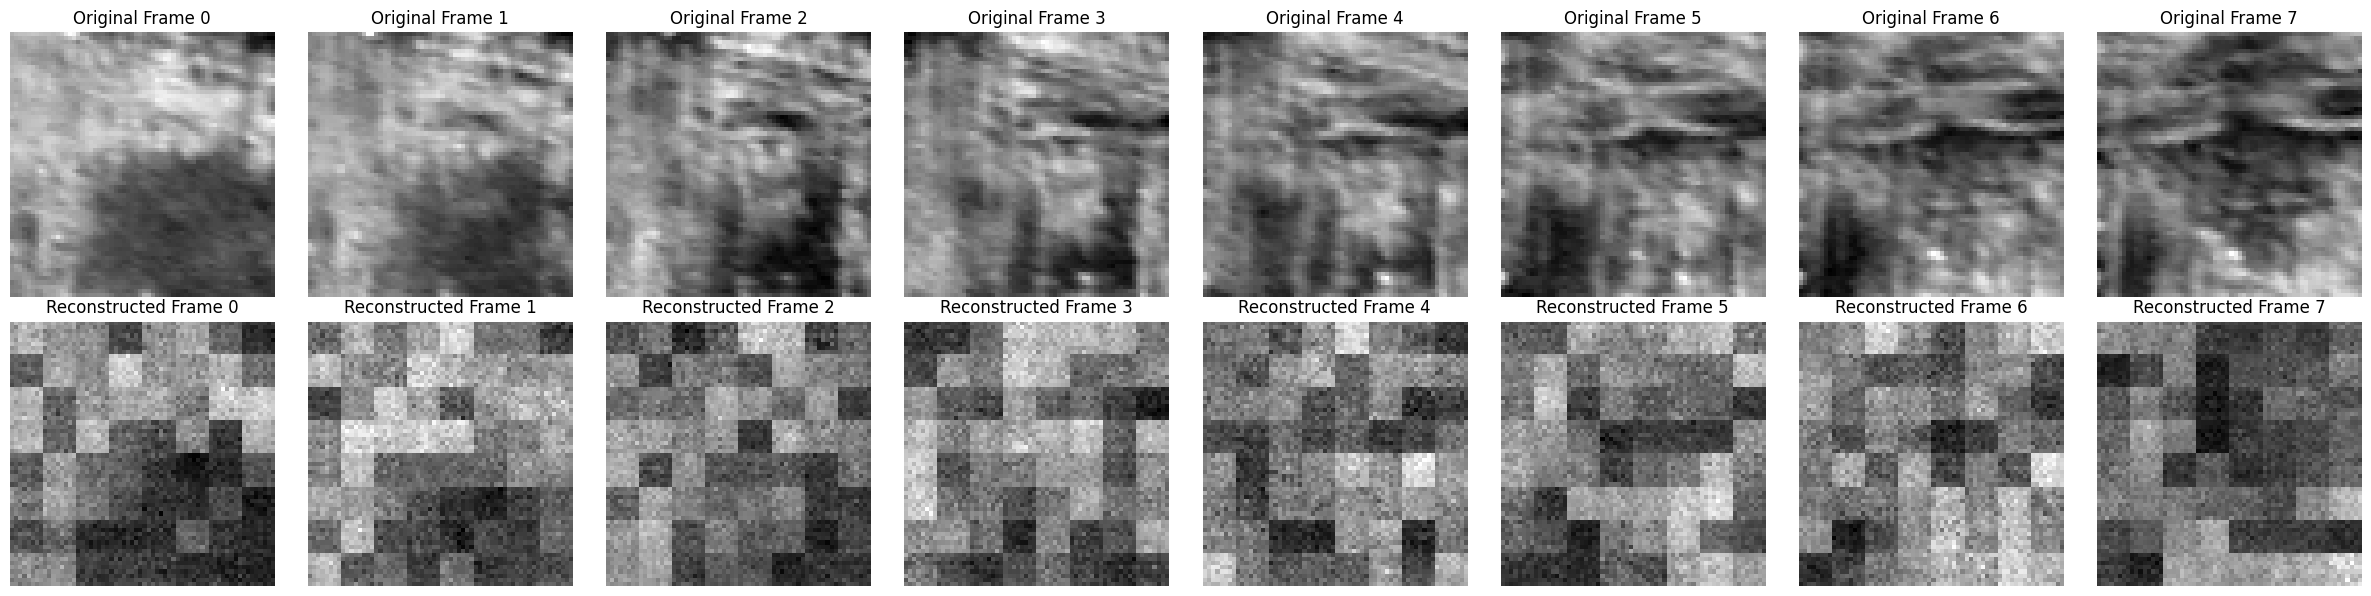

Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s, v_num=11, train_loss=0.0279, lr=2.52e-5, val_loss=0.0243]

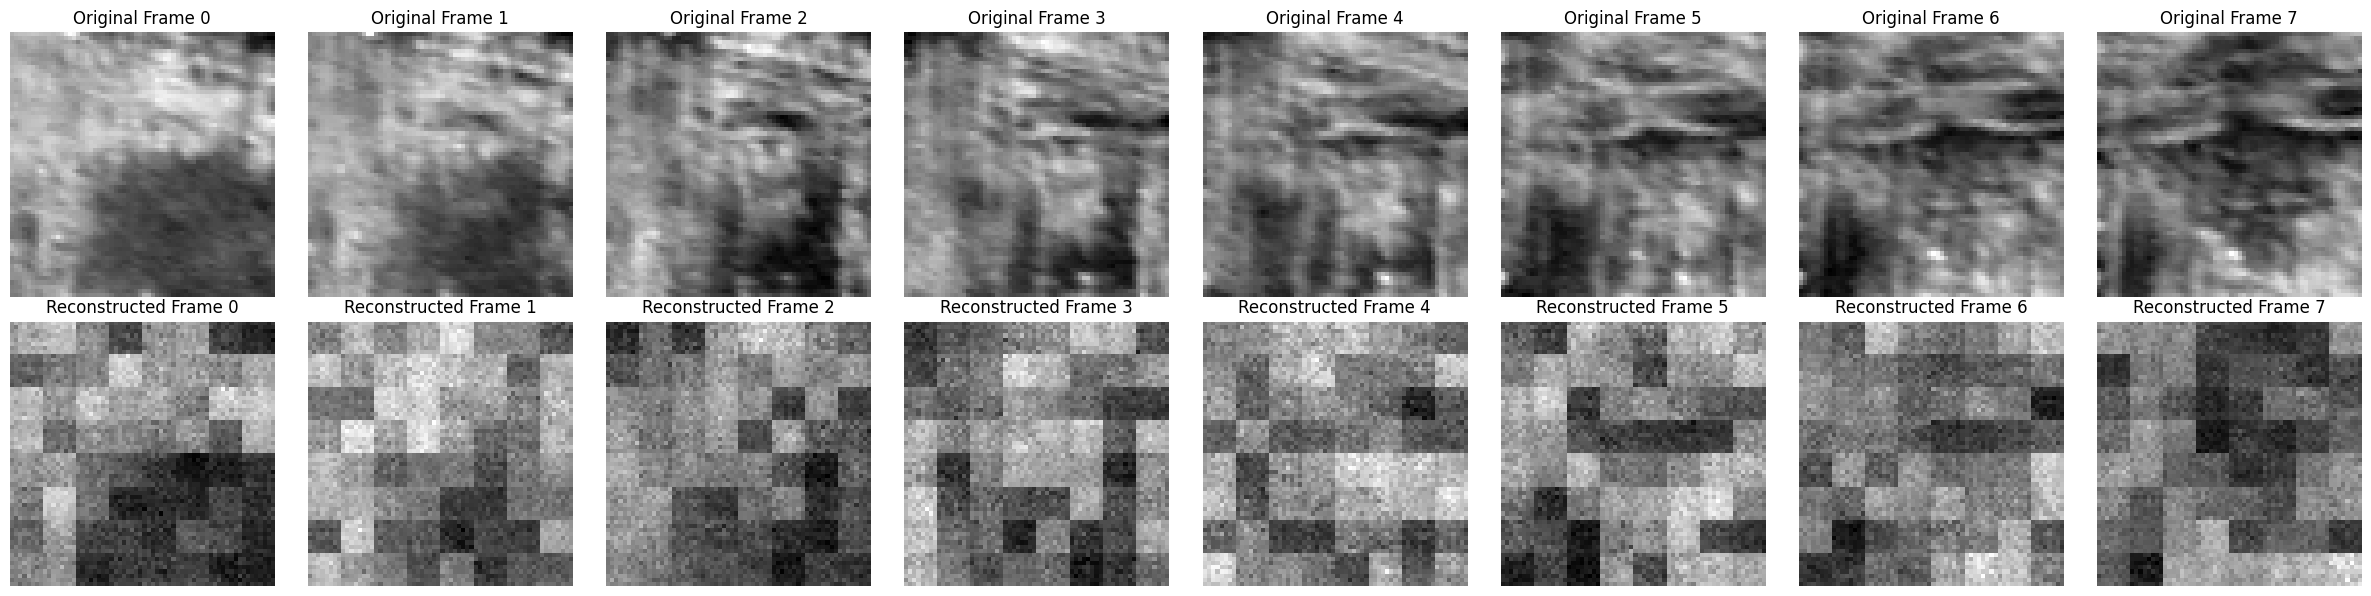

Epoch 159: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s, v_num=11, train_loss=0.0262, lr=1.3e-5, val_loss=0.021]  

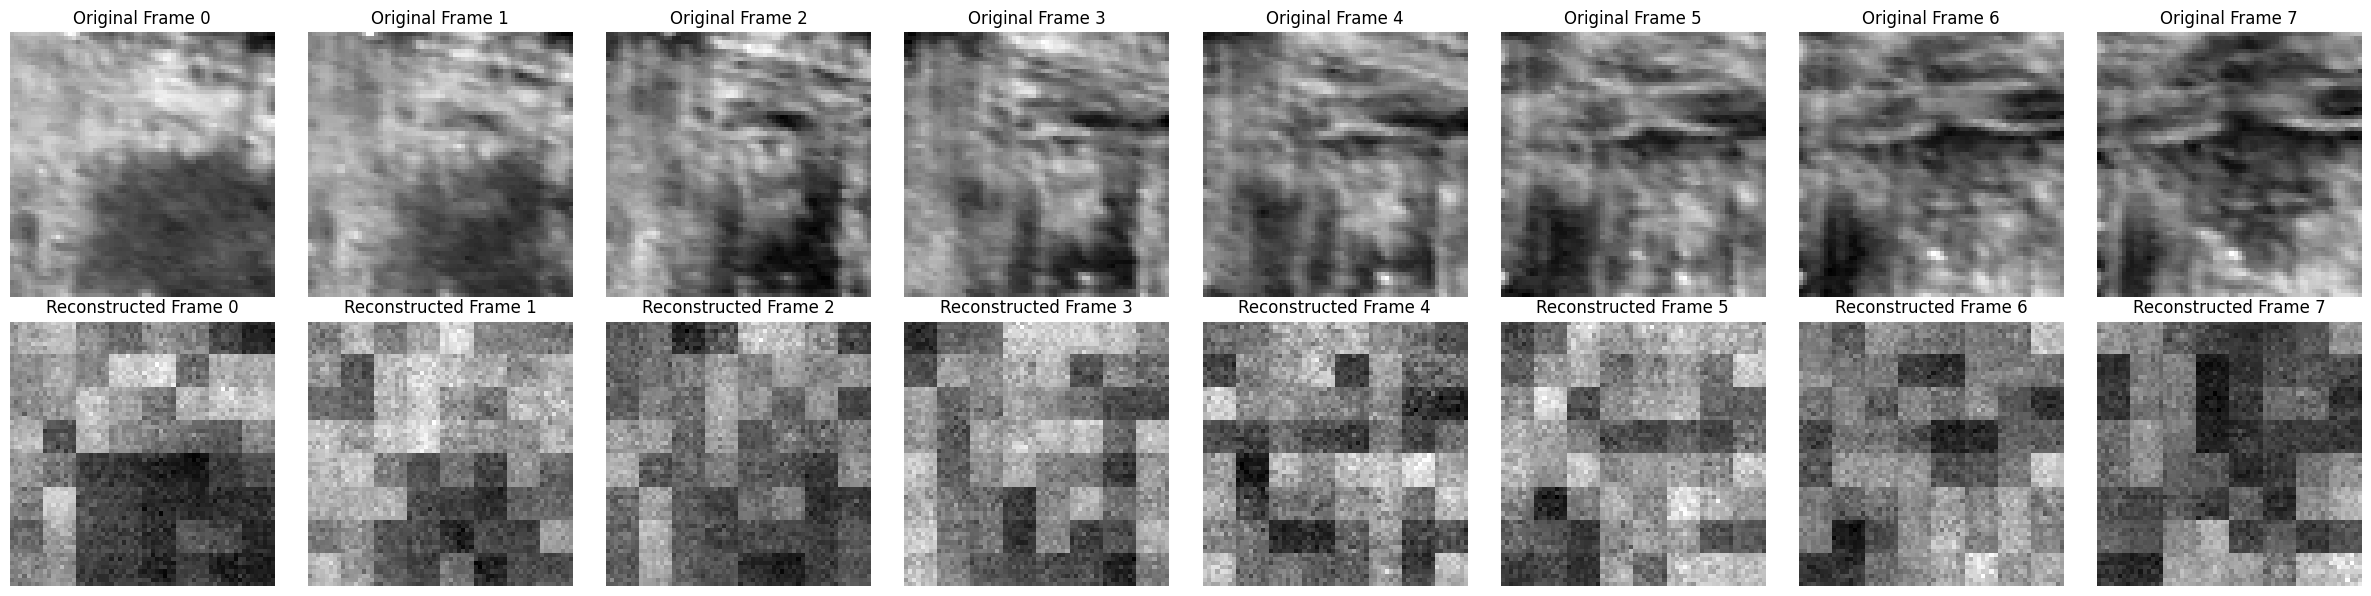

Epoch 179: 100%|██████████| 1/1 [00:00<00:00, 23.43it/s, v_num=11, train_loss=0.0253, lr=4.43e-6, val_loss=0.0207]

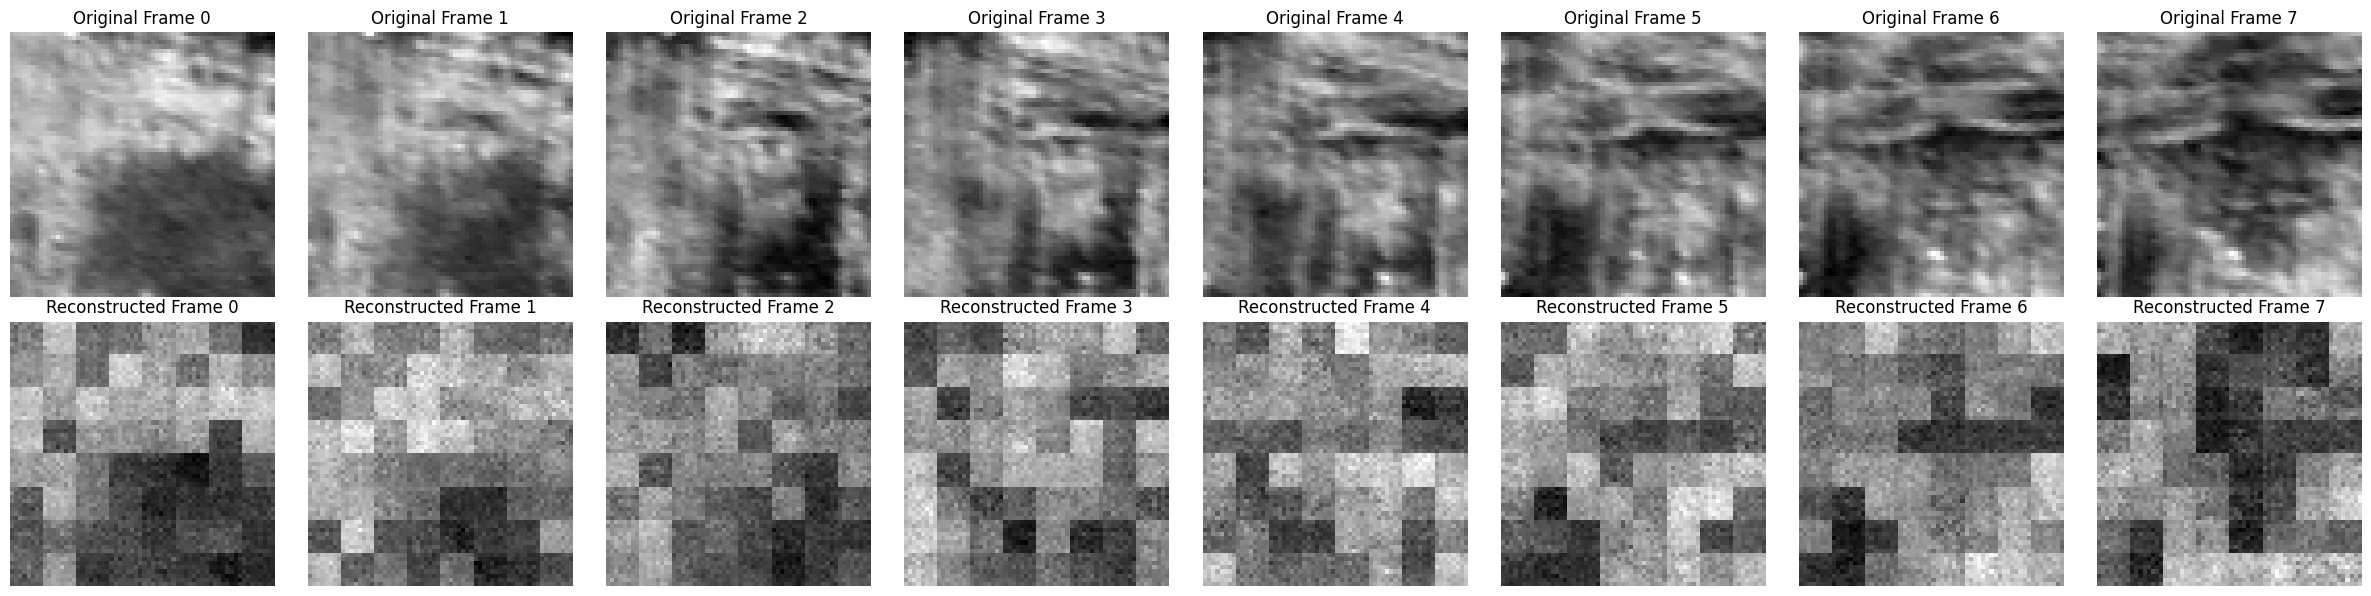

Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s, v_num=11, train_loss=0.0255, lr=3.02e-7, val_loss=0.020] 

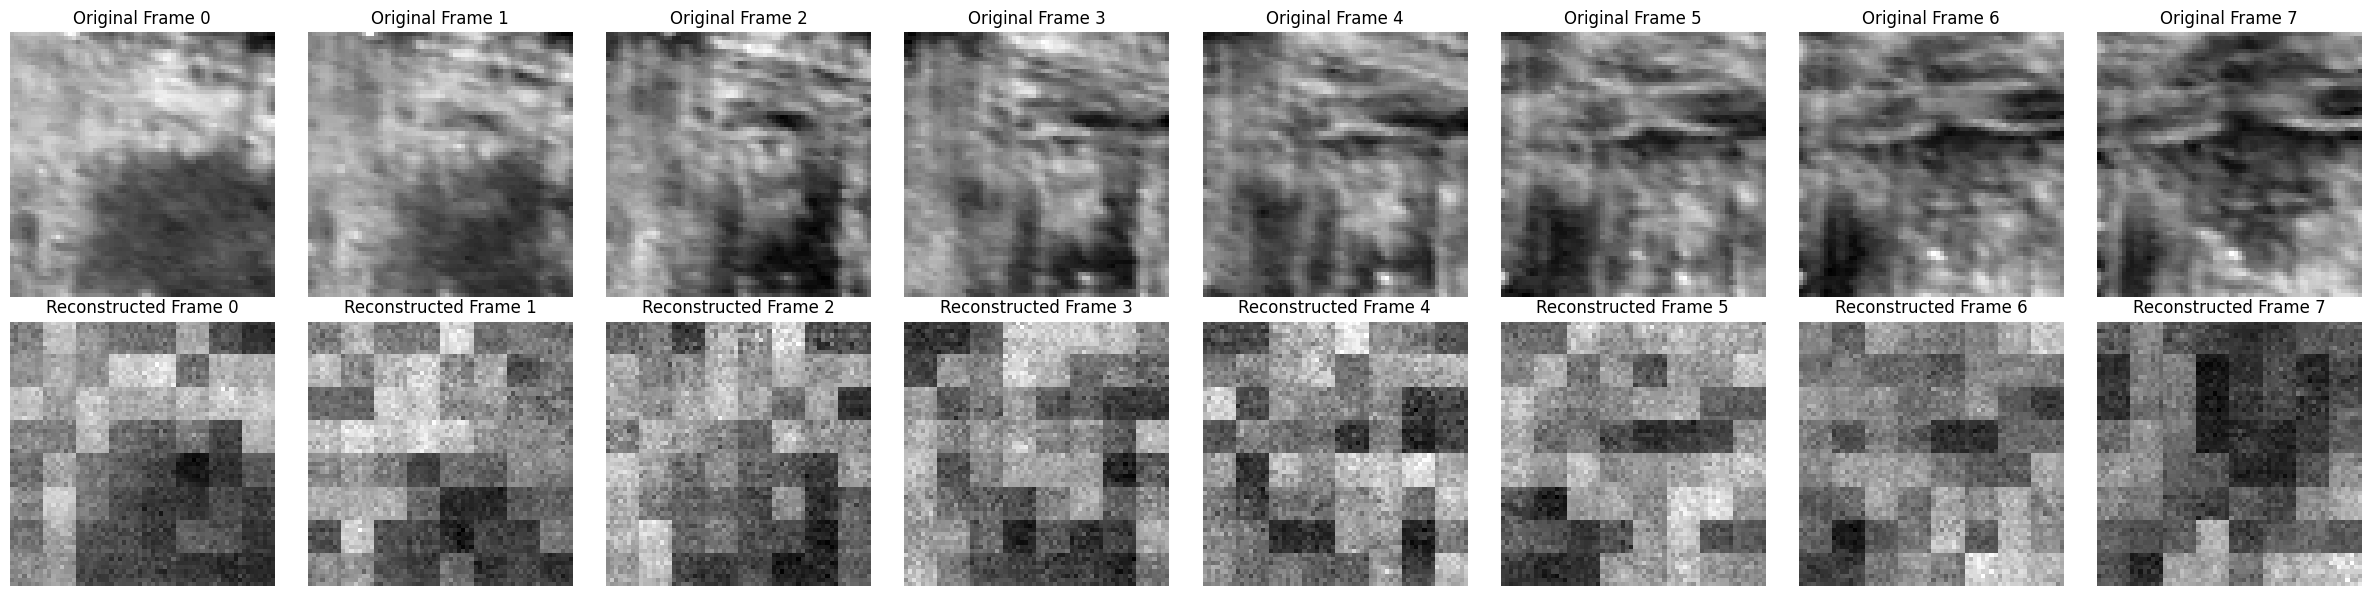

Epoch 199: 100%|██████████| 1/1 [00:03<00:00,  0.30it/s, v_num=11, train_loss=0.0255, lr=3.02e-7, val_loss=0.0197]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:03<00:00,  0.30it/s, v_num=11, train_loss=0.0255, lr=3.02e-7, val_loss=0.0197]


In [ ]:

import math
from torch.optim import AdamW
from warmup_scheduler import GradualWarmupScheduler
from transformers import SegformerForSemanticSegmentation
from torchvision.models.video import swin_transformer
import albumentations as A
from transformers import AutoImageProcessor, TimesformerModel
from transformers import TimesformerModel, TimesformerConfig

import numpy as np

class MAEPretrain(pl.LightningModule):
    def __init__(self, lr=4e-4, mask_ratio=0.75, embed_dim=512, decoder_dim=512, decoder_layers=4):
        super().__init__()
        self.save_hyperparameters()
        self.print_shape = False
        
        config = TimesformerConfig(
            num_frames=16,
            image_size=64,
            patch_size=8,
            num_channels=1,
            attention_type="divided_space_time",
            hidden_size=512,           # embedding dimension
            num_attention_heads=8,
            intermediate_size=512,
            num_hidden_layers=8        # <--- THIS is the depth (# of transformer blocks)
        )
        encoder = TimesformerModel(config)

        self.encoder = encoder

        self.patch_size = config.patch_size
        self.tubelet_size = 1
        self.input_T = config.num_frames
        self.input_H = config.image_size
        self.input_W = config.image_size
        self.mask_ratio = self.hparams.mask_ratio
        mse_loss = nn.MSELoss()

        self.criterion = lambda pred, target: mse_loss(pred, target)     
        
        self.N = self.input_T * self.input_H * self.input_W // (self.patch_size**2*self.tubelet_size)
        print(f"Total patches: {self.N}")

        target = (1- self.mask_ratio) * self.N  # example: 500        
        
        # Start by finding max possible y (perfect square root) that doesn't exceed target/input_T
        max_y = math.floor(math.sqrt(target / self.input_T))

        # Generate candidate numbers (num = y*y * input_T)
        candidates = [y*y * self.input_T for y in range(max_y, 0, -1)]

        # Pick the candidate closest to the target
        closest = min(candidates, key=lambda x: abs(x - target))
        
        self.unmasked_patches =  closest

        print("Unmasked_patches:", closest)

        print(f"Actual patches used: {self.unmasked_patches}/{self.N} : {self.unmasked_patches/self.N:.2f}")


        # Transformer decoder components
        self.decoder_embed = nn.Linear(embed_dim, decoder_dim)
        self.decoder_pos_embed = nn.Parameter(torch.randn(1, self.N, decoder_dim))
        
        decoder_layer = nn.TransformerEncoderLayer(d_model=decoder_dim, nhead=8, dim_feedforward=decoder_dim)
        self.decoder_transformer = nn.TransformerEncoder(decoder_layer, num_layers=decoder_layers)
        self.decoder_pred = nn.Sequential(
            nn.Linear(decoder_dim, self.patch_size**2),
            nn.Tanh()  # ensures outputs in [-1, 1]
        )

        # Mask token for masked patches in decoder
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_dim))
        nn.init.normal_(self.mask_token, std=0.02)
        

    def patchify(self, x):
        """
        x: (B, T, C, H, W)
        Returns:
            patches: (B, N, patch_dim)
            where N = (T//tubelet_size) * (H//patch_size) * (W//patch_size)
                    patch_dim = C * tubelet_size * patch_size * patch_size
        """
        B, T, C, H, W = x.shape
        tubelet = self.tubelet_size   # e.g., 2
        ps = self.patch_size          # e.g., 32

        # (B, T, C, H, W) → (B, C, T, H, W)
        x = x.permute(0, 2, 1, 3, 4)

        # Unfold temporal and spatial dims
        x = x.unfold(2, tubelet, tubelet) \
            .unfold(3, ps, ps) \
            .unfold(4, ps, ps)
        # shape: (B, C, T_patches, H_patches, W_patches, tubelet, ps, ps)

        T_patches = x.size(2)
        H_patches = x.size(3)
        W_patches = x.size(4)

        # Reorder: (B, T_p, H_p, W_p, tubelet, ps, ps, C)
        x = x.permute(0, 2, 3, 4, 5, 6, 7, 1)

        # Flatten each patch: (B, N, C * tubelet * ps * ps)
        x = x.reshape(B, T_patches * H_patches * W_patches,
                    C * tubelet * ps * ps)

        return x

    
    def unpatchify(self, x, patch_shape):
        # x: (B, N, D)
        B, N, D = x.shape
        pt, ph, pw = patch_shape
        ps = self.patch_size
        tubelet = self.tubelet_size
        C = 1
        assert ph * pw * pt == N, "Patch count mismatch"
        x = x.view(B, pt, ph, pw, C, tubelet, ps, ps)                  # (..., C, tubelet, ps, ps)
        x = x.permute(0, 4, 1, 5, 2, 6, 3, 7).contiguous()             # (B, C, pt, tubelet, ph, ps, pw, ps)
        x = x.view(B, C, pt * tubelet, ph * ps, pw * ps)               # (B, C, T, H, W)
        return x
    


    def frame_masking(self, x, mask_ratio=0.75):
        """
        Frame-level masking applied to patchified input.
        x: (B, N, D) where 
        N = (T//tubelet) * (H//ps) * (W//ps)
        Returns:
            x_masked:   (B, n_keep*H_p*W_p, D)
            ids_keep:   (B, n_keep*H_p*W_p)
            ids_masked: (B, n_mask*H_p*W_p)
            ids_restore:(B, N)  - to restore original order
        """
        B, N, D = x.shape
        T_groups = self.input_T // self.tubelet_size   # e.g., 16
        H_groups = self.input_H // self.patch_size     # e.g., 7
        W_groups = self.input_W // self.patch_size     # e.g., 7

        patches_per_frame = H_groups * W_groups
        assert N == T_groups * patches_per_frame, "Patch count mismatch"

        n_keep_frames = 2#int((1 - mask_ratio) * T_groups)
        # n_keep = n_keep_frames * patches_per_frame

        ids_keep, ids_masked, ids_restore = [], [], []

        for b in range(B):
            # permute frames
            perm_frames = torch.randperm(T_groups, device=x.device)
            keep_frames = perm_frames[:n_keep_frames]
            mask_frames = perm_frames[n_keep_frames:]

            # expand to patch indices
            keep_idx = (keep_frames[:, None] * patches_per_frame +
                        torch.arange(patches_per_frame, device=x.device)[None, :])
            mask_idx = (mask_frames[:, None] * patches_per_frame +
                        torch.arange(patches_per_frame, device=x.device)[None, :])

            keep_idx = keep_idx.flatten()
            mask_idx = mask_idx.flatten()

            # build restore index
            perm = torch.cat([keep_idx, mask_idx], dim=0)
            ids_restore_b = torch.empty_like(perm)
            ids_restore_b[perm] = torch.arange(N, device=x.device)

            ids_keep.append(keep_idx)
            ids_masked.append(mask_idx)
            ids_restore.append(ids_restore_b)

        ids_keep = torch.stack(ids_keep, dim=0)      # (B, n_keep)
        ids_masked = torch.stack(ids_masked, dim=0)  # (B, n_mask)
        ids_restore = torch.stack(ids_restore, dim=0) # (B, N)

        # gather visible patches
        x_masked = torch.gather(x, 1, ids_keep.unsqueeze(-1).expand(-1, -1, D))

        return x_masked, ids_keep, ids_masked, ids_restore

    def random_masking(self, x, mask_ratio=0.75):
        """
        MAE-style random masking with restore indices.
        x: (B, N, D)
        Returns:
            x_masked: (B, n_keep, D)    - visible patches
            ids_keep: (B, n_keep)       - indices of kept patches
            ids_masked: (B, n_mask)     - indices of masked patches
            ids_restore: (B, N)         - to restore original order
        """
        B, N, D = x.shape
        n_keep = self.unmasked_patches

        ids_keep = []
        ids_masked = []
        ids_restore = []

        for b in range(B):
            # 1. Random permutation of all patches
            perm = torch.randperm(N, device=x.device)
            keep = perm[:n_keep]
            masked = perm[n_keep:]

            # 2. Save indices
            ids_keep.append(keep)
            ids_masked.append(masked)

            # 3. Build restore index (inverse of permutation)
            ids_restore_b = torch.empty_like(perm)
            ids_restore_b[perm] = torch.arange(N, device=x.device)
            ids_restore.append(ids_restore_b)


        ids_keep = torch.stack(ids_keep, dim=0)      # (B, n_keep)
        ids_masked = torch.stack(ids_masked, dim=0)  # (B, n_mask)
        ids_restore = torch.stack(ids_restore, dim=0) # (B, N)

        # 4. Gather kept tokens
        x_masked = torch.gather(x, 1, ids_keep.unsqueeze(-1).expand(-1, -1, D))

        return x_masked, ids_keep, ids_masked, ids_restore

    def forward(self, x):
        B, T, C, H, W = x.shape # (B, T, C, H, W)
        
        # 1. Patchify input video
        x_patched = self.patchify(x)  # (B, N, D)
        if self.print_shape:
            print('x_patched: ',x_patched.shape) # (B,N,T,D)
        
        N = x_patched.shape[1] 

        # 2. Mask patches
        x_masked, ids_keep, ids_masked, ids_restore = self.random_masking(x_patched, self.mask_ratio)
        if self.print_shape:
            print('x_masked',x_masked.shape) # (B,N,T,D)
            
        ids_keep = ids_keep.long() # Ids of unmasked
        ids_masked = ids_masked.long()
        ids_restore = ids_restore.long()

        # Calculate masked patch indices
        all_ids = torch.arange(N, device=x.device).unsqueeze(0).expand(B, -1)  # (B, N)
        mask = torch.ones_like(all_ids, dtype=torch.bool)
        mask.scatter_(1, ids_keep, False)
        
        pt = 4#T // self.tubelet_size 
        ph = pw = int((self.unmasked_patches // pt) ** 0.5)
        if self.print_shape:
            print(pt,ph,pw)
        assert ph * pw * pt == self.unmasked_patches, "Patch grid mismatch"

        # We know the tube shape is (pt, square_size, square_size)
        x_masked_video = self.unpatchify(x_masked, (pt, ph, pw))  # (B, C, T, H_mask, W_mask)
        if self.print_shape:
            print('x_masked_unpatchify',x_masked_video.shape)
        
        
        # 4. Encoder forward on masked video        
        x_masked_video = x_masked_video.permute(0,2,1,3,4) # (B,T,C,H,W)
        outputs = self.encoder(x_masked_video, output_hidden_states=True)
        tokens = outputs.last_hidden_state[:,1:,:]  # tuple of all hidden layers
        if self.print_shape:
            print('tokens: ',tokens.shape) # (B, n_visible, D)
        
        # 5. Embed encoder features to decoder_dim
        x_vis = self.decoder_embed(tokens)  # (B, n_visible, decoder_dim)
        
        x_vis = x_vis.view(B,-1,self.hparams.decoder_dim)
        if self.print_shape:
            print(x_vis.shape)

        # 6. Prepare mask tokens for masked patches
        mask_tokens = self.mask_token.expand(B, ids_masked.shape[1], -1)  # (B, n_masked, decoder_dim)

        # print(mask_tokens.shape)
        # 7. Create full sequence tensor for decoder input
        # Restore to original order
        x_ = torch.cat([x_vis, mask_tokens], dim=1)  # (B, n_keep + n_masked, D)
        x_dec = torch.gather(x_, 1, ids_restore.unsqueeze(-1).expand(-1, -1, x_.shape[2]))
        
        # 8. Add positional embedding
        x_dec = x_dec + self.decoder_pos_embed

        # 9. Decode full sequence
        x_dec = self.decoder_transformer(x_dec)
        pred = self.decoder_pred(x_dec)  # (B, N, patch_dim)
        
        # 3. Unpatchify visible patches to video for encoder
        pt = T // self.tubelet_size
        ph = pw = int((self.N // pt) ** 0.5)
        recon = self.unpatchify(pred, (pt, ph, pw))  # (B, C, T, H, W)
        recon = recon.permute(0, 2, 1, 3, 4)  # (B, T, C, H, W)

        return recon, x_masked_video, mask, ids_masked, pred, x_patched
    
    def training_step(self, batch, batch_idx):
        x, y = batch  # (B, 1, T, H, W)
        B = x.shape[0]

        recon, x_masked, mask, ids_masked, pred, target = self(x)

        # Gather masked predictions & targets per device
        B, N, D = pred.shape
        device = pred.device

        # ids_masked: (B, n_mask)
        ids_masked_exp = ids_masked.unsqueeze(-1).expand(-1, -1, D)  # (B, n_mask, D)

        pred_masked   = torch.gather(pred,   1, ids_masked_exp)  # (B, n_mask, D)
        target_masked = torch.gather(target, 1, ids_masked_exp)  # (B, n_mask, D)

        # Compute loss only on masked patches
        loss = self.criterion(pred_masked, target_masked)
        self.log("train_loss", loss, prog_bar=True, logger=True, sync_dist=True)  # sync across devices
        self.log("lr", self.optimizers().param_groups[0]['lr'], prog_bar=True, logger=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        recon, _, mask, _, _, _ = self(x)
        loss = self.criterion(recon, x)
        self.log('val_loss', loss, prog_bar=True)
        # Save first batch to visualize later
        if batch_idx == 0:
            self.val_batch_for_viz = (x, mask, recon)
        return loss

    def on_validation_epoch_end(self):
        if hasattr(self, 'val_batch_for_viz'):
            x, mask, recon = self.val_batch_for_viz
            visualize_reconstruction(x, recon, sample_idx=0, num_frames=8)

    def configure_optimizers(self):

        optimizer = AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-7)

        # Cosine LR with warmup
        cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
        scheduler = GradualWarmupScheduler(
            optimizer, multiplier=1, total_epoch=5, after_scheduler=cosine_scheduler
        )

        return [optimizer], [scheduler]


model = MAEPretrain()
trainer = pl.Trainer(
    max_epochs=200,
    accelerator='auto',
    log_every_n_steps=20,
    check_val_every_n_epoch=20,
)
trainer.fit(model, train_loader, train_loader)

# SWIN

## 224*224

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Total patches: 196
Actual patches used: 49/196 : 0.25



  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | encoder             | Sequential         | 27.8 M | train
1 | decoder_embed       | Linear             | 393 K  | train
2 | decoder_transformer | TransformerEncoder | 6.3 M  | train
3 | decoder_pred        | Sequential         | 1.1 M  | train
  | other params        | n/a                | 100 K  | n/a  
-------------------------------------------------------------------
35.7 M    Trainable params
0         Non-trainable params
35.7 M    Total params
142.806   Total estimated model params size (MB)
222       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]x_masked torch.Size([10, 49, 2048])
x_masked_unpatchify torch.Size([10, 1, 2, 224, 224])
x_dec torch.Size([10, 196, 512])
torch.Size([1, 196, 512])
4 7 7
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 24.75it/s]x_masked torch.Size([10, 49, 2048])
x_masked_unpatchify torch.Size([10, 1, 2, 224, 224])
x_dec torch.Size([10, 196, 512])
torch.Size([1, 196, 512])
4 7 7
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 23.90it/s]

/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


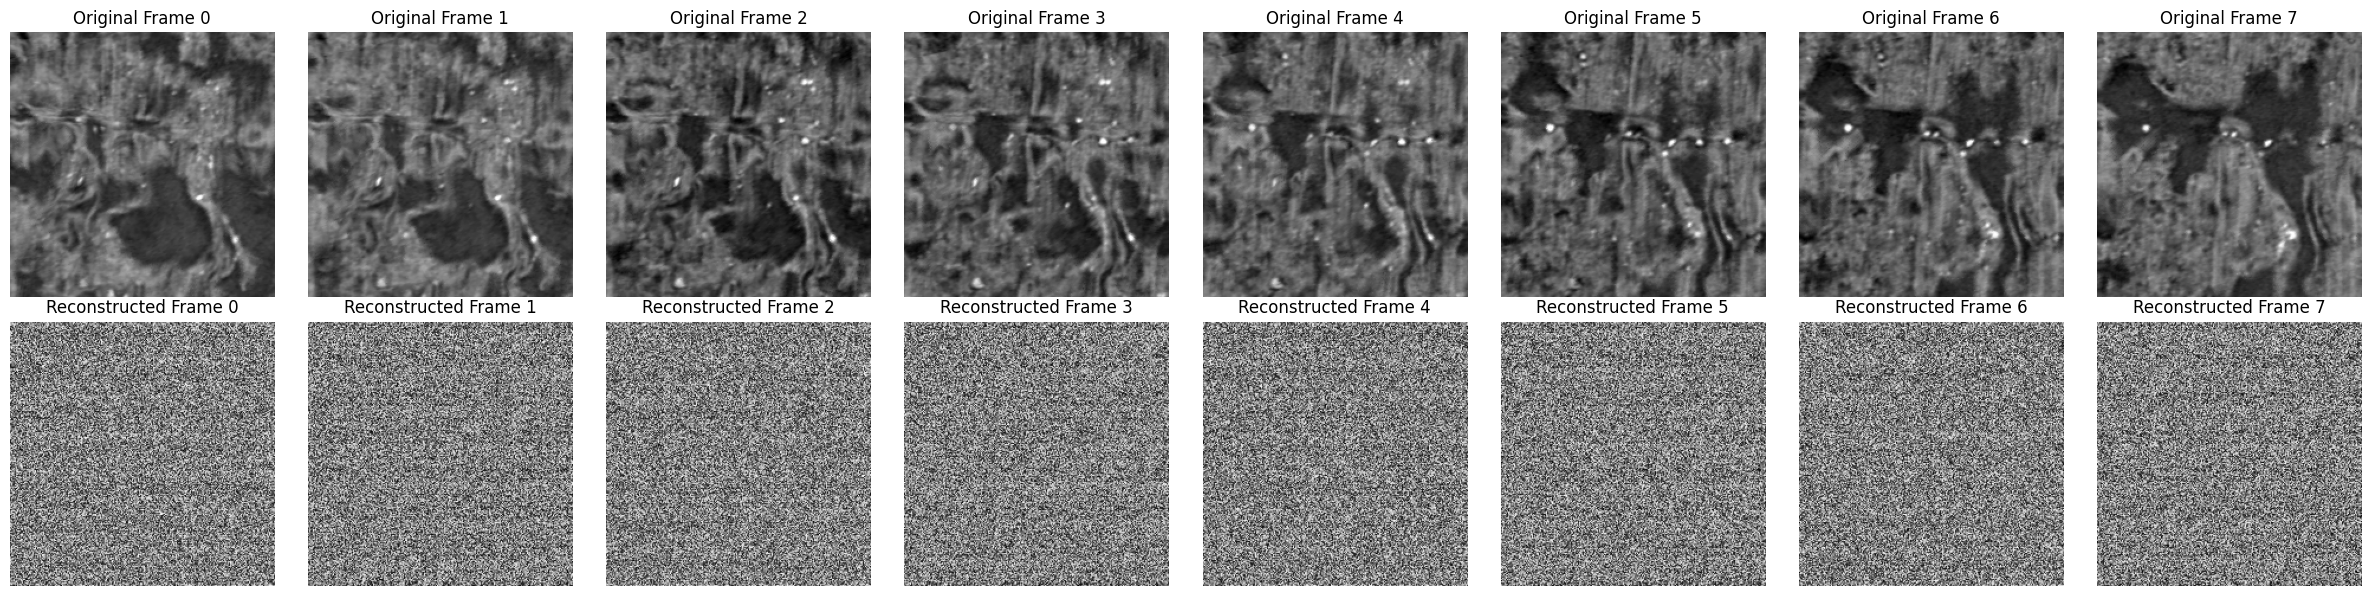

/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/159 [00:00<?, ?it/s] x_masked torch.Size([10, 49, 2048])
x_masked_unpatchify torch.Size([10, 1, 2, 224, 224])
x_dec torch.Size([10, 196, 512])
torch.Size([1, 196, 512])
4 7 7
Epoch 0:   1%|          | 1/159 [00:00<00:38,  4.13it/s, v_num=17, train_loss=0.301]x_masked torch.Size([10, 49, 2048])
x_masked_unpatchify torch.Size([10, 1, 2, 224, 224])
x_dec torch.Size([10, 196, 512])
torch.Size([1, 196, 512])
4 7 7
Epoch 0:   1%|▏         | 2/159 [00:00<00:25,  6.20it/s, v_num=17, train_loss=0.319]x_masked torch.Size([10, 49, 2048])
x_masked_unpatchify torch.Size([10, 1, 2, 224, 224])
x_dec torch.Size([10, 196, 512])
torch.Size([1, 196, 512])
4 7 7
Epoch 0:   2%|▏         | 3/159 [00:00<00:20,  7.55it/s, v_num=17, train_loss=0.291]x_masked torch.Size([10, 49, 2048])
x_masked_unpatchify torch.Size([10, 1, 2, 224, 224])
x_dec torch.Size([10, 196, 512])
torch.Size([1, 196, 512])
4 7 7
Epoch 0:   3%|▎         | 4/159 [00:00<00:18,  8.46it/s, v_num=17, train_loss=0.318


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
import math
from torch.optim import AdamW
from warmup_scheduler import GradualWarmupScheduler
from transformers import SegformerForSemanticSegmentation
from torchvision.models.video import swin_transformer
import albumentations as A
from transformers import AutoImageProcessor, TimesformerModel
from transformers import TimesformerModel, TimesformerConfig
import numpy as np

class MAEPretrain(pl.LightningModule):
    def __init__(self, lr=1e-3, mask_ratio=0.75, embed_dim=768, decoder_dim=512, decoder_layers=4):
        super().__init__()
        self.save_hyperparameters()
        
    
        # self.encoder  = swin_transformer.swin3d_t(weights="KINETICS400_V1") #KINETICS400_IMAGENET22K_V1
        # backbone = swin_transformer.swin3d_b(weights='KINETICS400_V1') #KINETICS400_IMAGENET22K_V1
        # Load pretrained Swin3D backbone
        backbone = swin_transformer.swin3d_t(weights='KINETICS400_V1')

        # Get old weights
        old_conv = backbone.patch_embed.proj  # Conv3d(3, 128, ...)
        weight = old_conv.weight  # [128, 3, 2, 4, 4]
        bias = old_conv.bias      # [128]

        # Adapt weights: average across RGB → 1 channel
        new_weight = weight.sum(dim=1, keepdim=True)  # [128, 1, 2, 4, 4]

        # Replace conv with new one (keep out_channels=128!)
        backbone.patch_embed.proj = nn.Conv3d(
            in_channels=1,
            out_channels=128,
            kernel_size=(2, 4, 4),
            stride=(2, 4, 4),
            bias=True
        )

        # Load adapted weights
        backbone.patch_embed.proj.weight = nn.Parameter(new_weight)
        backbone.patch_embed.proj.bias = nn.Parameter(bias.clone())  # shape [128]
        self.encoder = nn.Sequential(*list(backbone.children())[:-2]) 
        
        self.patch_size = 32
        self.input_T = 8
        self.input_H = 224
        self.input_W = 224
        self.tubelet_size = 2
        self.mask_ratio = self.hparams.mask_ratio
        mse_loss = nn.MSELoss()
        l1_loss = nn.L1Loss()

        self.criterion = lambda pred, target: 1 * mse_loss(pred, target) #+ 0.5 * l1_loss(pred, target)        
        
        # self.N = self.input_T * self.input_H * self.input_W // (self.patch_size**2*2)
        self.N = (self.input_T // self.tubelet_size) * \
         (self.input_H // self.patch_size) * \
         (self.input_W // self.patch_size)
        print(f"Total patches: {self.N}")

        self.unmasked_patches =  49#int((1- self.mask_ratio)* self.input_T)*28
        print(f"Actual patches used: {self.unmasked_patches}/{self.N} : {self.unmasked_patches/self.N:.2f}")

        # Transformer decoder components
        self.decoder_embed = nn.Linear(embed_dim, decoder_dim)
        self.decoder_pos_embed = nn.Parameter(torch.randn(1, self.N, decoder_dim))
        # print(self.decoder_pos_embed.shape)
        # pos_embed = get_3d_sincos_pos_embed(decoder_dim,  self.input_T//self.tubelet_size,  self.input_H//self.patch_size,  self.input_W//self.patch_size)  # [1, N, D]
        # print(pos_embed.shape)
        # self.decoder_pos_embed = nn.Parameter(pos_embed, requires_grad=False)  # fixed
        # print('self.decoder_pos_embed.shape',self.decoder_pos_embed.shape)

        
        decoder_layer = nn.TransformerEncoderLayer(d_model=decoder_dim, nhead=8, dim_feedforward=decoder_dim, batch_first=True)
        self.decoder_transformer = nn.TransformerEncoder(decoder_layer, num_layers=decoder_layers)
        self.decoder_pred = nn.Sequential(
            nn.Linear(decoder_dim, self.patch_size**2*self.tubelet_size),
            nn.Tanh()
        )

        # Mask token for masked patches in decoder
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_dim))
        nn.init.normal_(self.mask_token, std=0.02)
        
        
    def patchify(self, x):
        """
        x: (B, T, C, H, W)
        Returns:
            patches: (B, N, patch_dim)
            where N = (T//tubelet_size) * (H//patch_size) * (W//patch_size)
                    patch_dim = C * tubelet_size * patch_size * patch_size
        """
        B, T, C, H, W = x.shape
        tubelet = self.tubelet_size   # e.g., 2
        ps = self.patch_size          # e.g., 32

        # (B, T, C, H, W) → (B, C, T, H, W)
        x = x.permute(0, 2, 1, 3, 4)
        
        # Unfold temporal and spatial dims
        x = x.unfold(2, tubelet, tubelet) \
            .unfold(3, ps, ps) \
            .unfold(4, ps, ps)
        # shape: (B, C, T_patches, H_patches, W_patches, tubelet, ps, ps)

        T_patches = x.size(2)
        H_patches = x.size(3)
        W_patches = x.size(4)

        # Reorder: (B, T_p, H_p, W_p, tubelet, ps, ps, C)
        x = x.permute(0, 2, 3, 4, 5, 6, 7, 1)

        # Flatten each patch: (B, N, C * tubelet * ps * ps)
        x = x.reshape(B, T_patches * H_patches * W_patches,
                    C * tubelet * ps * ps)
        # print(x.shape)
        return x

    
    def unpatchify(self, x, patch_shape):
        # x: (B, N, D)
        B, N, D = x.shape
        pt, ph, pw = patch_shape
        ps = self.patch_size
        tubelet = self.tubelet_size
        C = 1
        assert ph * pw * pt == N, "Patch count mismatch"
        x = x.view(B, pt, ph, pw, C, tubelet, ps, ps)                  # (..., C, tubelet, ps, ps)
        x = x.permute(0, 4, 1, 5, 2, 6, 3, 7).contiguous()             # (B, C, pt, tubelet, ph, ps, pw, ps)
        x = x.view(B, C, pt * tubelet, ph * ps, pw * ps)               # (B, C, T, H, W)
        return x
    
    def frame_masking(self, x, mask_ratio=0.75):
        """
        Frame-level masking applied to patchified input.
        x: (B, N, D) where 
        N = (T//tubelet) * (H//ps) * (W//ps)
        Returns:
            x_masked:   (B, n_keep*H_p*W_p, D)
            ids_keep:   (B, n_keep*H_p*W_p)
            ids_masked: (B, n_mask*H_p*W_p)
            ids_restore:(B, N)  - to restore original order
        """
        B, N, D = x.shape
        T_groups = self.input_T // self.tubelet_size   # e.g., 4
        H_groups = self.input_H // self.patch_size     # e.g., 7
        W_groups = self.input_W // self.patch_size     # e.g., 7
        # print(T_groups,H_groups,W_groups)
        # print(N)
        patches_per_frame = H_groups * W_groups
        assert N == T_groups * patches_per_frame, "Patch count mismatch"

        n_keep_frames = 1#int((1 - mask_ratio) * T_groups)
        n_keep = n_keep_frames * patches_per_frame

        ids_keep, ids_masked, ids_restore = [], [], []

        for b in range(B):
            # permute frames
            perm_frames = torch.randperm(T_groups, device=x.device)
            keep_frames = perm_frames[:n_keep_frames]
            mask_frames = perm_frames[n_keep_frames:]

            # expand to patch indices
            keep_idx = (keep_frames[:, None] * patches_per_frame +
                        torch.arange(patches_per_frame, device=x.device)[None, :])
            mask_idx = (mask_frames[:, None] * patches_per_frame +
                        torch.arange(patches_per_frame, device=x.device)[None, :])

            keep_idx = keep_idx.flatten()
            mask_idx = mask_idx.flatten()

            # build restore index
            perm = torch.cat([keep_idx, mask_idx], dim=0)
            ids_restore_b = torch.empty_like(perm)
            ids_restore_b[perm] = torch.arange(N, device=x.device)

            ids_keep.append(keep_idx)
            ids_masked.append(mask_idx)
            ids_restore.append(ids_restore_b)

        ids_keep = torch.stack(ids_keep, dim=0)      # (B, n_keep)
        ids_masked = torch.stack(ids_masked, dim=0)  # (B, n_mask)
        ids_restore = torch.stack(ids_restore, dim=0) # (B, N)

        # gather visible patches
        x_masked = torch.gather(x, 1, ids_keep.unsqueeze(-1).expand(-1, -1, D))

        return x_masked, ids_keep, ids_masked, ids_restore

    def tube_masking(self, x, mask_ratio=0.75):
        """
        Tube-level masking applied to patchified input.
        x: (B, N, D) where 
            N = (T//tubelet) * (H//ps) * (W//ps)
        Returns:
            x_masked:   (B, n_keep*D)
            ids_keep:   (B, n_keep)
            ids_masked: (B, n_mask)
            ids_restore:(B, N)  - to restore original order
        """
        B, N, D = x.shape
        T_groups = self.input_T // self.tubelet_size   # temporal groups
        H_groups = self.input_H // self.patch_size     # spatial groups (height)
        W_groups = self.input_W // self.patch_size     # spatial groups (width)

        num_tubes = H_groups * W_groups  # number of spatial tube locations
        tube_len = T_groups              # length of each tube (temporal depth)

        # # each "tube" corresponds to all temporal positions at one (h, w)
        assert N == num_tubes * tube_len, "Patch count mismatch"

        n_keep_tubes = self.N - self.unmasked_patches

        ids_keep, ids_masked, ids_restore = [], [], []

        for b in range(B):
            # permute tube positions
            perm_tubes = torch.randperm(num_tubes, device=x.device)
            keep_tubes = perm_tubes[:n_keep_tubes]
            mask_tubes = perm_tubes[n_keep_tubes:]

            # expand tube indices across time
            keep_idx = (keep_tubes[:, None] * tube_len +
                        torch.arange(tube_len, device=x.device)[None, :])
            mask_idx = (mask_tubes[:, None] * tube_len +
                        torch.arange(tube_len, device=x.device)[None, :])

            keep_idx = keep_idx.flatten()
            mask_idx = mask_idx.flatten()

            # build restore index
            perm = torch.cat([keep_idx, mask_idx], dim=0)
            ids_restore_b = torch.empty_like(perm)
            ids_restore_b[perm] = torch.arange(N, device=x.device)

            ids_keep.append(keep_idx)
            ids_masked.append(mask_idx)
            ids_restore.append(ids_restore_b)

        ids_keep = torch.stack(ids_keep, dim=0)      # (B, n_keep)
        ids_masked = torch.stack(ids_masked, dim=0)  # (B, n_mask)
        ids_restore = torch.stack(ids_restore, dim=0) # (B, N)

        # gather visible patches
        x_masked = torch.gather(x, 1, ids_keep.unsqueeze(-1).expand(-1, -1, D))

        return x_masked, ids_keep, ids_masked, ids_restore


    def random_masking(self, x, mask_ratio=0.75):
        """
        MAE-style random masking with restore indices.
        x: (B, N, D)
        Returns:
            x_masked: (B, n_keep, D)    - visible patches
            ids_keep: (B, n_keep)       - indices of kept patches
            ids_masked: (B, n_mask)     - indices of masked patches
            ids_restore: (B, N)         - to restore original order
        """
        B, N, D = x.shape
        n_keep = self.unmasked_patches

        ids_keep = []
        ids_masked = []
        ids_restore = []

        for b in range(B):
            # 1. Random permutation of all patches
            perm = torch.randperm(N, device=x.device)
            keep = perm[:n_keep]
            masked = perm[n_keep:]

            # 2. Save indices
            ids_keep.append(keep)
            ids_masked.append(masked)

            # 3. Build restore index (inverse of permutation)
            ids_restore_b = torch.empty_like(perm)
            ids_restore_b[perm] = torch.arange(N, device=x.device)
            ids_restore.append(ids_restore_b)
            # ids_restore_b = torch.empty(N, device=x.device, dtype=torch.long)
            # ids_restore_b[keep]   = torch.arange(n_keep, device=x.device)
            # ids_restore_b[masked] = torch.arange(n_keep, N, device=x.device)
            # ids_restore.append(ids_restore_b)

        ids_keep = torch.stack(ids_keep, dim=0)      # (B, n_keep)
        ids_masked = torch.stack(ids_masked, dim=0)  # (B, n_mask)
        ids_restore = torch.stack(ids_restore, dim=0) # (B, N)

        # 4. Gather kept tokens
        x_masked = torch.gather(x, 1, ids_keep.unsqueeze(-1).expand(-1, -1, D))

        return x_masked, ids_keep, ids_masked, ids_restore
    

    def forward(self, x):
        B, T, C, H, W = x.shape # (B, T, C, H, W)

        # print(x.shape)
        # 1. Patchify input video
        x_patched = self.patchify(x)  # (B, N, D)
        # print('x_patched',x_patched.shape) # (B,N,T,D)
        
        N = x_patched.shape[1]

        # 2. Mask patches
        x_masked, ids_keep, ids_masked, ids_restore = self.random_masking(x_patched, self.mask_ratio)
        
        print('x_masked',x_masked.shape) # (B,N,T,D)
        ids_keep = ids_keep.long() # Ids of unmasked
        ids_masked = ids_masked.long()
        ids_restore = ids_restore.long()

        # Calculate masked patch indices
        all_ids = torch.arange(N, device=x.device).unsqueeze(0).expand(B, -1)  # (B, N)
        mask = torch.ones_like(all_ids, dtype=torch.bool)
        mask.scatter_(1, ids_keep, False)
        
        pt = T // self.tubelet_size -3
        ph = pw = int((self.unmasked_patches // pt) ** 0.5)
        # print('ph,pw,pt',ph,pw,pt)
        assert ph * pw * pt == self.unmasked_patches, "Patch grid mismatch"

        # We know the tube shape is (pt, square_size, square_size)
        x_masked_video = self.unpatchify(x_masked, (pt, ph, pw))  # (B, C, T, H_mask, W_mask)
        print('x_masked_unpatchify',x_masked_video.shape)
        
        # 4. Encoder forward on masked video        
        # x_masked_video = x_masked_video.permute(0,2,1,3,4) # (B,T,C,H,W)
        outputs = self.encoder(x_masked_video)
        # print('outputs',outputs.shape)
        # Group first
        tokens = outputs#.view(B, pt, ph, pw, self.hparams.embed_dim)  # (B, 16, 8, 8, D)
        # tokens = tokens.view(B, ph, pw, T, self.hparams.embed_dim)  # (B, 16, 8, 8, D)
        # tokens = tokens.permute(0, 3, 1, 2, 4).contiguous()         # (B, ph, pw, T, D)  <-- matches your compact cube order
        # print(tokens.shape)

        # 5. Embed encoder features to decoder_dim
        x_vis = self.decoder_embed(tokens)  # (B, n_visible, decoder_dim)
        
        x_vis = x_vis.view(B,-1,self.hparams.decoder_dim)
        # print(x_vis.shape)

        # 6. Prepare mask tokens for masked patches
        # print(ids_masked.shape[1])

        mask_tokens = self.mask_token.expand(B, ids_masked.shape[1], -1)  # (B, n_masked, decoder_dim)
        # x_ = torch.cat([x_vis, mask_tokens], dim=1)   # (B, N, D) but shuffled
        # x_dec = torch.gather(x_, 1, ids_restore.unsqueeze(-1).expand(-1, -1, x_vis.shape[2]))

        # print(mask_tokens.shape)
        # 7. Create full sequence tensor for decoder input
        # Restore to original order
        x_ = torch.cat([x_vis, mask_tokens], dim=1)  # (B, n_keep + n_masked, D)
        # print(x.shape)
        x_dec = torch.gather(x_, 1, ids_restore.unsqueeze(-1).expand(-1, -1, x_.shape[2]))
        print('x_dec',x_dec.shape)
        print(self.decoder_pos_embed.shape)
        # 8. Add positional embedding
        x_dec = x_dec + self.decoder_pos_embed
    


        # 9. Decode full sequence
        x_dec = self.decoder_transformer(x_dec)
        # print('x_dec',x_dec.shape)
        pred = self.decoder_pred(x_dec)  # (B, N, patch_dim)
        # print(pred.shape)
        
        # pred_masked = pred.clone()
        # pred_masked[mask == 0] = 0  # zero out unmasked tokens
        
        # 3. Unpatchify visible patches to video for encoder
        pt = 4
        ph = pw = int((self.N // pt) ** 0.5)
        print(pt,ph,pw)
        # 
        recon = self.unpatchify(pred, (pt, ph, pw))  # (B, C, T, H, W)
        recon = recon.permute(0, 2, 1, 3, 4)  # (B, T, C, H, W)
        # print(recon.shape)
        return recon, x_masked_video, mask, ids_masked, pred, x_patched

    def training_step(self, batch, batch_idx):
        x, y = batch  # (B, 1, T, H, W)
        B = x.shape[0]

        recon, x_masked, mask, ids_masked, pred, target = self(x)

        # Gather masked predictions & targets per device
        B, N, D = pred.shape
        device = pred.device

        # ids_masked: (B, n_mask)
        ids_masked_exp = ids_masked.unsqueeze(-1).expand(-1, -1, D)  # (B, n_mask, D)

        pred_masked   = torch.gather(pred,   1, ids_masked_exp)  # (B, n_mask, D)
        target_masked = torch.gather(target, 1, ids_masked_exp)  # (B, n_mask, D)

        # Compute loss only on masked patches
        loss = self.criterion(pred_masked, target_masked)
        self.log("train_loss", loss, prog_bar=True, logger=True, sync_dist=True)  # sync across devices

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        recon, _, mask, _, _, _ = self(x)
        loss = self.criterion(recon, x)
        self.log('val_loss', loss, prog_bar=True)
        # Save first batch to visualize later
        if batch_idx == 0:
            self.val_batch_for_viz = (x, mask, recon)
        return loss

    def on_validation_epoch_end(self):
        if hasattr(self, 'val_batch_for_viz'):
            x, mask, recon = self.val_batch_for_viz
            visualize_reconstruction(x, recon, sample_idx=0, num_frames=8)

    # def configure_optimizers(self):
    #     optimizer = AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-6)
    #     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    #     return [optimizer], [scheduler]
    def configure_optimizers(self):
        optimizer = AdamW([
            {'params': self.encoder.parameters(), 'lr': 2e-5, 'weight_decay': 1e-7},
            {'params': list(self.decoder_embed.parameters()) +
                    list(self.decoder_transformer.parameters()) +
                    list(self.decoder_pred.parameters()), 
            'lr': 1e-4, 'weight_decay': 1e-7}
        ])

        # Cosine LR with warmup
        cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)
        scheduler = GradualWarmupScheduler(
            optimizer, multiplier=1, total_epoch=10, after_scheduler=cosine_scheduler
        )

        return [optimizer], [scheduler]



model = MAEPretrain()
trainer = pl.Trainer(
    max_epochs=1000,
    accelerator='auto',
    log_every_n_steps=20,
    check_val_every_n_epoch=50,
)
trainer.fit(model, valid_loader, valid_loader)

## 64X64

In [18]:
import math
from torch.optim import AdamW
from warmup_scheduler import GradualWarmupScheduler
from transformers import SegformerForSemanticSegmentation
from torchvision.models.video import swin_transformer
import albumentations as A
from transformers import AutoImageProcessor, TimesformerModel
from transformers import TimesformerModel, TimesformerConfig
import numpy as np

class MAEPretrain(pl.LightningModule):
    def __init__(self, lr=1e-4, mask_ratio=0.75, embed_dim=768, decoder_dim=512, decoder_layers=4):
        super().__init__()
        self.save_hyperparameters()
        
    
        # self.encoder  = swin_transformer.swin3d_t(weights="KINETICS400_V1") #KINETICS400_IMAGENET22K_V1
        # backbone = swin_transformer.swin3d_b(weights='KINETICS400_V1') #KINETICS400_IMAGENET22K_V1
        # Load pretrained Swin3D backbone
        backbone = swin_transformer.swin3d_s(weights='KINETICS400_V1')

        # Get old weights
        old_conv = backbone.patch_embed.proj  # Conv3d(3, 128, ...)
        weight = old_conv.weight  # [128, 3, 2, 4, 4]
        bias = old_conv.bias      # [128]

        # Adapt weights: average across RGB → 1 channel
        new_weight = weight.sum(dim=1, keepdim=True)  # [128, 1, 2, 4, 4]

        # Replace conv with new one (keep out_channels=128!)
        backbone.patch_embed.proj = nn.Conv3d(
            in_channels=1,
            out_channels=128,
            kernel_size=(2, 4, 4),
            stride=(2, 4, 4),
            bias=True
        )

        # Load adapted weights
        backbone.patch_embed.proj.weight = nn.Parameter(new_weight)
        backbone.patch_embed.proj.bias = nn.Parameter(bias.clone())  # shape [128]
        self.encoder = nn.Sequential(*list(backbone.children())[:-2]) 
        
        self.patch_size = 32
        self.input_T = 16
        self.input_H = 64
        self.input_W = 64
        self.tubelet_size = 2
        self.mask_ratio = self.hparams.mask_ratio
        mse_loss = nn.MSELoss()
        l1_loss = nn.L1Loss()

        self.criterion = lambda pred, target: 1 * mse_loss(pred, target) #+ 0.5 * l1_loss(pred, target)        
        
        # self.N = self.input_T * self.input_H * self.input_W // (self.patch_size**2*2)
        self.N = (self.input_T // self.tubelet_size) * \
         (self.input_H // self.patch_size) * \
         (self.input_W // self.patch_size)
        print(f"Total patches: {self.N}")

        self.unmasked_patches =  int((1- self.mask_ratio)* self.input_T/self.tubelet_size)* self.input_H//self.patch_size* self.input_W//self.patch_size
        print(f"Actual patches used: {self.unmasked_patches}/{self.N} : {self.unmasked_patches/self.N:.2f}")

        # Transformer decoder components
        self.decoder_embed = nn.Linear(embed_dim, decoder_dim)
        self.decoder_pos_embed = nn.Parameter(torch.randn(1, self.N, decoder_dim))
        
        decoder_layer = nn.TransformerEncoderLayer(d_model=decoder_dim, nhead=8, dim_feedforward=decoder_dim, batch_first=True)
        self.decoder_transformer = nn.TransformerEncoder(decoder_layer, num_layers=decoder_layers)
        self.decoder_pred = nn.Sequential(
            nn.Linear(decoder_dim, self.patch_size**2*self.tubelet_size),
            nn.Tanh()
        )

        # Mask token for masked patches in decoder
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_dim))
        nn.init.normal_(self.mask_token, std=0.02)
        
    def patchify(self, x):
        """
        x: (B, T, C, H, W)
        Returns:
            patches: (B, N, patch_dim)
            where N = (T//tubelet_size) * (H//patch_size) * (W//patch_size)
                    patch_dim = C * tubelet_size * patch_size * patch_size
        """
        B, T, C, H, W = x.shape
        tubelet = self.tubelet_size   # e.g., 2
        ps = self.patch_size          # e.g., 32

        # (B, T, C, H, W) → (B, C, T, H, W)
        x = x.permute(0, 2, 1, 3, 4)
        
        # Unfold temporal and spatial dims
        x = x.unfold(2, tubelet, tubelet) \
            .unfold(3, ps, ps) \
            .unfold(4, ps, ps)
        # shape: (B, C, T_patches, H_patches, W_patches, tubelet, ps, ps)

        T_patches = x.size(2)
        H_patches = x.size(3)
        W_patches = x.size(4)

        # Reorder: (B, T_p, H_p, W_p, tubelet, ps, ps, C)
        x = x.permute(0, 2, 3, 4, 5, 6, 7, 1)

        # Flatten each patch: (B, N, C * tubelet * ps * ps)
        x = x.reshape(B, T_patches * H_patches * W_patches,
                    C * tubelet * ps * ps)
        # print(x.shape)
        return x

    
    def unpatchify(self, x, patch_shape):
        # x: (B, N, D)
        B, N, D = x.shape
        pt, ph, pw = patch_shape
        ps = self.patch_size
        tubelet = self.tubelet_size
        C = 1
        assert ph * pw * pt == N, "Patch count mismatch"
        x = x.view(B, pt, ph, pw, C, tubelet, ps, ps)                  # (..., C, tubelet, ps, ps)
        x = x.permute(0, 4, 1, 5, 2, 6, 3, 7).contiguous()             # (B, C, pt, tubelet, ph, ps, pw, ps)
        x = x.view(B, C, pt * tubelet, ph * ps, pw * ps)               # (B, C, T, H, W)
        return x
    
    def frame_masking(self, x, mask_ratio=0.75):
        """
        Frame-level masking applied to patchified input.
        x: (B, N, D) where 
        N = (T//tubelet) * (H//ps) * (W//ps)
        Returns:
            x_masked:   (B, n_keep*H_p*W_p, D)
            ids_keep:   (B, n_keep*H_p*W_p)
            ids_masked: (B, n_mask*H_p*W_p)
            ids_restore:(B, N)  - to restore original order
        """
        B, N, D = x.shape
        T_groups = self.input_T // self.tubelet_size   # e.g., 4
        H_groups = self.input_H // self.patch_size     # e.g., 7
        W_groups = self.input_W // self.patch_size     # e.g., 7
        # print(T_groups,H_groups,W_groups)
        # print(N)
        patches_per_frame = H_groups * W_groups
        assert N == T_groups * patches_per_frame, "Patch count mismatch"

        n_keep_frames = int((1 - mask_ratio) * T_groups)
        n_keep = n_keep_frames * patches_per_frame

        ids_keep, ids_masked, ids_restore = [], [], []

        for b in range(B):
            # permute frames
            perm_frames = torch.randperm(T_groups, device=x.device)
            keep_frames = perm_frames[:n_keep_frames]
            mask_frames = perm_frames[n_keep_frames:]

            # expand to patch indices
            keep_idx = (keep_frames[:, None] * patches_per_frame +
                        torch.arange(patches_per_frame, device=x.device)[None, :])
            mask_idx = (mask_frames[:, None] * patches_per_frame +
                        torch.arange(patches_per_frame, device=x.device)[None, :])

            keep_idx = keep_idx.flatten()
            mask_idx = mask_idx.flatten()

            # build restore index
            perm = torch.cat([keep_idx, mask_idx], dim=0)
            ids_restore_b = torch.empty_like(perm)
            ids_restore_b[perm] = torch.arange(N, device=x.device)

            ids_keep.append(keep_idx)
            ids_masked.append(mask_idx)
            ids_restore.append(ids_restore_b)

        ids_keep = torch.stack(ids_keep, dim=0)      # (B, n_keep)
        ids_masked = torch.stack(ids_masked, dim=0)  # (B, n_mask)
        ids_restore = torch.stack(ids_restore, dim=0) # (B, N)

        # gather visible patches
        x_masked = torch.gather(x, 1, ids_keep.unsqueeze(-1).expand(-1, -1, D))

        return x_masked, ids_keep, ids_masked, ids_restore

    def tube_masking(self, x, mask_ratio=0.75):
        """
        Tube-level masking applied to patchified input.
        x: (B, N, D) where 
            N = (T//tubelet) * (H//ps) * (W//ps)
        Returns:
            x_masked:   (B, n_keep*D)
            ids_keep:   (B, n_keep)
            ids_masked: (B, n_mask)
            ids_restore:(B, N)  - to restore original order
        """
        B, N, D = x.shape
        T_groups = self.input_T // self.tubelet_size   # temporal groups
        H_groups = self.input_H // self.patch_size     # spatial groups (height)
        W_groups = self.input_W // self.patch_size     # spatial groups (width)

        num_tubes = H_groups * W_groups  # number of spatial tube locations
        tube_len = T_groups              # length of each tube (temporal depth)

        # # each "tube" corresponds to all temporal positions at one (h, w)
        assert N == num_tubes * tube_len, "Patch count mismatch"

        n_keep_tubes = self.N - self.unmasked_patches

        ids_keep, ids_masked, ids_restore = [], [], []

        for b in range(B):
            # permute tube positions
            perm_tubes = torch.randperm(num_tubes, device=x.device)
            keep_tubes = perm_tubes[:n_keep_tubes]
            mask_tubes = perm_tubes[n_keep_tubes:]

            # expand tube indices across time
            keep_idx = (keep_tubes[:, None] * tube_len +
                        torch.arange(tube_len, device=x.device)[None, :])
            mask_idx = (mask_tubes[:, None] * tube_len +
                        torch.arange(tube_len, device=x.device)[None, :])

            keep_idx = keep_idx.flatten()
            mask_idx = mask_idx.flatten()

            # build restore index
            perm = torch.cat([keep_idx, mask_idx], dim=0)
            ids_restore_b = torch.empty_like(perm)
            ids_restore_b[perm] = torch.arange(N, device=x.device)

            ids_keep.append(keep_idx)
            ids_masked.append(mask_idx)
            ids_restore.append(ids_restore_b)

        ids_keep = torch.stack(ids_keep, dim=0)      # (B, n_keep)
        ids_masked = torch.stack(ids_masked, dim=0)  # (B, n_mask)
        ids_restore = torch.stack(ids_restore, dim=0) # (B, N)

        # gather visible patches
        x_masked = torch.gather(x, 1, ids_keep.unsqueeze(-1).expand(-1, -1, D))

        return x_masked, ids_keep, ids_masked, ids_restore


    def random_masking(self, x, mask_ratio=0.75):
        """
        MAE-style random masking with restore indices.
        x: (B, N, D)
        Returns:
            x_masked: (B, n_keep, D)    - visible patches
            ids_keep: (B, n_keep)       - indices of kept patches
            ids_masked: (B, n_mask)     - indices of masked patches
            ids_restore: (B, N)         - to restore original order
        """
        B, N, D = x.shape
        n_keep = self.unmasked_patches

        ids_keep = []
        ids_masked = []
        ids_restore = []

        for b in range(B):
            # 1. Random permutation of all patches
            perm = torch.randperm(N, device=x.device)
            keep = perm[:n_keep]
            masked = perm[n_keep:]

            # 2. Save indices
            ids_keep.append(keep)
            ids_masked.append(masked)

            # 3. Build restore index (inverse of permutation)
            ids_restore_b = torch.empty_like(perm)
            ids_restore_b[perm] = torch.arange(N, device=x.device)
            ids_restore.append(ids_restore_b)

        ids_keep = torch.stack(ids_keep, dim=0)      # (B, n_keep)
        ids_masked = torch.stack(ids_masked, dim=0)  # (B, n_mask)
        ids_restore = torch.stack(ids_restore, dim=0) # (B, N)

        # 4. Gather kept tokens
        x_masked = torch.gather(x, 1, ids_keep.unsqueeze(-1).expand(-1, -1, D))

        return x_masked, ids_keep, ids_masked, ids_restore
    

    def forward(self, x):
        B, T, C, H, W = x.shape # (B, T, C, H, W)

        # print(x.shape)
        # 1. Patchify input video
        x_patched = self.patchify(x)  # (B, N, D)
        # print('x_patched',x_patched.shape) # (B,N,T,D)
        
        N = x_patched.shape[1]

        # 2. Mask patches
        x_masked, ids_keep, ids_masked, ids_restore = self.frame_masking(x_patched, self.mask_ratio)
        
        # print('x_masked',x_masked.shape) # (B,N,T,D)
        ids_keep = ids_keep.long() # Ids of unmasked
        ids_masked = ids_masked.long()
        ids_restore = ids_restore.long()

        # Calculate masked patch indices
        all_ids = torch.arange(N, device=x.device).unsqueeze(0).expand(B, -1)  # (B, N)
        mask = torch.ones_like(all_ids, dtype=torch.bool)
        mask.scatter_(1, ids_keep, False)
        
        pt = int((self.input_T // self.tubelet_size)*(1-self.mask_ratio))
        ph = pw = int((self.unmasked_patches // pt) ** 0.5)
        assert ph * pw * pt == self.unmasked_patches, "Patch grid mismatch"

        # We know the tube shape is (pt, square_size, square_size)
        x_masked_video = self.unpatchify(x_masked, (pt, ph, pw))  # (B, C, T, H_mask, W_mask)
        # print('x_masked_unpatchify',x_masked_video.shape)
        
        # 4. Encoder forward on masked video        
        # x_masked_video = x_masked_video.permute(0,2,1,3,4) # (B,T,C,H,W)
        outputs = self.encoder(x_masked_video)
        # print('outputs',outputs.shape)
        # Group first
        tokens = outputs#.view(B, pt, ph, pw, self.hparams.embed_dim)  # (B, 16, 8, 8, D)
        # tokens = tokens.view(B, ph, pw, T, self.hparams.embed_dim)  # (B, 16, 8, 8, D)
        # tokens = tokens.permute(0, 3, 1, 2, 4).contiguous()         # (B, ph, pw, T, D)  <-- matches your compact cube order
        # print(tokens.shape)

        # 5. Embed encoder features to decoder_dim
        x_vis = self.decoder_embed(tokens)  # (B, n_visible, decoder_dim)
        
        x_vis = x_vis.view(B,-1,self.hparams.decoder_dim)
        # print(x_vis.shape)

        # 6. Prepare mask tokens for masked patches
        # print(ids_masked.shape[1])

        mask_tokens = self.mask_token.expand(B, ids_masked.shape[1], -1)  # (B, n_masked, decoder_dim)
        # x_ = torch.cat([x_vis, mask_tokens], dim=1)   # (B, N, D) but shuffled
        # x_dec = torch.gather(x_, 1, ids_restore.unsqueeze(-1).expand(-1, -1, x_vis.shape[2]))

        # print(mask_tokens.shape)
        # 7. Create full sequence tensor for decoder input
        # Restore to original order
        x_ = torch.cat([x_vis, mask_tokens], dim=1)  # (B, n_keep + n_masked, D)
        # print(x.shape)
        x_dec = torch.gather(x_, 1, ids_restore.unsqueeze(-1).expand(-1, -1, x_.shape[2]))

        # 8. Add positional embedding
        x_dec = x_dec + self.decoder_pos_embed
    
        # 9. Decode full sequence
        x_dec = self.decoder_transformer(x_dec)
        # print('x_dec',x_dec.shape)
        pred = self.decoder_pred(x_dec)  # (B, N, patch_dim)
        
        # 3. Unpatchify visible patches to video for encoder
        pt = self.input_T // self.tubelet_size
        ph = pw = int((self.N // pt) ** 0.5)
        # print(pt,ph,pw)
        # 
        recon = self.unpatchify(pred, (pt, ph, pw))  # (B, C, T, H, W)
        recon = recon.permute(0, 2, 1, 3, 4)  # (B, T, C, H, W)
        # print(recon.shape)
        return recon, x_masked_video, mask, ids_masked, pred, x_patched

    def training_step(self, batch, batch_idx):
        x, y = batch  # (B, 1, T, H, W)
        B = x.shape[0]

        recon, x_masked, mask, ids_masked, pred, target = self(x)

        # Gather masked predictions & targets per device
        B, N, D = pred.shape
        device = pred.device

        # ids_masked: (B, n_mask)
        ids_masked_exp = ids_masked.unsqueeze(-1).expand(-1, -1, D)  # (B, n_mask, D)

        pred_masked   = torch.gather(pred,   1, ids_masked_exp)  # (B, n_mask, D)
        target_masked = torch.gather(target, 1, ids_masked_exp)  # (B, n_mask, D)

        # Compute loss only on masked patches
        loss = self.criterion(pred_masked, target_masked)
        self.log("train_loss", loss, prog_bar=True, logger=True, sync_dist=True)  # sync across devices
        self.log("lr", self.optimizers().param_groups[0]['lr'], prog_bar=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        recon, _, mask, _, _, _ = self(x)
        loss = self.criterion(recon, x)
        self.log('val_loss', loss, prog_bar=True)
        # Save first batch to visualize later
        if batch_idx == 0:
            self.val_batch_for_viz = (x, mask, recon)
        return loss

    def on_validation_epoch_end(self):
        if hasattr(self, 'val_batch_for_viz'):
            x, mask, recon = self.val_batch_for_viz
            visualize_reconstruction(x, recon, sample_idx=0, num_frames=8)
            
    def configure_optimizers(self):
        optimizer = AdamW([
            {'params': self.encoder.parameters(), 'lr': 2e-5, 'weight_decay': 1e-7},
            {'params': list(self.decoder_embed.parameters()) +
                    list(self.decoder_transformer.parameters()) +
                    list(self.decoder_pred.parameters()), 
            'lr': 1e-4, 'weight_decay': 1e-7}
        ])

        # Cosine LR with warmup
        cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)
        scheduler = GradualWarmupScheduler(
            optimizer, multiplier=1, total_epoch=10, after_scheduler=cosine_scheduler
        )

        return [optimizer], [scheduler]



model = MAEPretrain()
trainer = pl.Trainer(
    max_epochs=1000,
    accelerator='auto',
    log_every_n_steps=20,
    check_val_every_n_epoch=100,
)
trainer.fit(model, train_loader, train_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | encoder             | Sequential         | 49.5 M | train
1 | decoder_embed       | Linear             | 393 K  | train
2 | decoder_transformer | TransformerEncoder | 6.3 M  | train
3 | decoder_pred        | Sequential         | 1.1 M  | train
  | other params   

Total patches: 32
Actual patches used: 8/32 : 0.25
                                                  

`Trainer.fit` stopped: No training batches.


In [ ]:
import torch
from torchvision.models.video import swin_transformer

# ---- Build model ----
model = swin_transformer.SwinTransformer3d(
    patch_size=[2, 4, 4],      # temporal=2, spatial=4x4 patches
    embed_dim=112,              # base dimension
    depths=[2, 2, 10, 2],       # Tiny config
    num_heads=[3, 6, 12, 24],  # heads per stage
    window_size=[8, 7, 7],     # attention window
    stochastic_depth_prob=0.1, # DropPath
)

model = nn.Sequential(*list(model.children())[:-2]) 

# ---- Example input ----
# Shape: (batch, channels, time, height, width)
x = torch.randn(2,3, 16, 64, 64)  # batch=2, 1 channel, 16 frames, 64x64

# ---- Forward pass ----
with torch.no_grad():
    out = model(x)

print("Output shape:", out.shape)


Output shape: torch.Size([2, 8, 2, 2, 768])


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Total patches: 32
Actual patches used: 8/32 : 0.25



  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | encoder             | Sequential         | 38.7 M | train
1 | decoder_embed       | Linear             | 393 K  | train
2 | decoder_transformer | TransformerEncoder | 6.3 M  | train
3 | decoder_pred        | Sequential         | 1.1 M  | train
  | other params        | n/a                | 16.9 K | n/a  
-------------------------------------------------------------------
46.4 M    Trainable params
0         Non-trainable params
46.4 M    Total params
185.787   Total estimated model params size (MB)
300       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.95it/s]

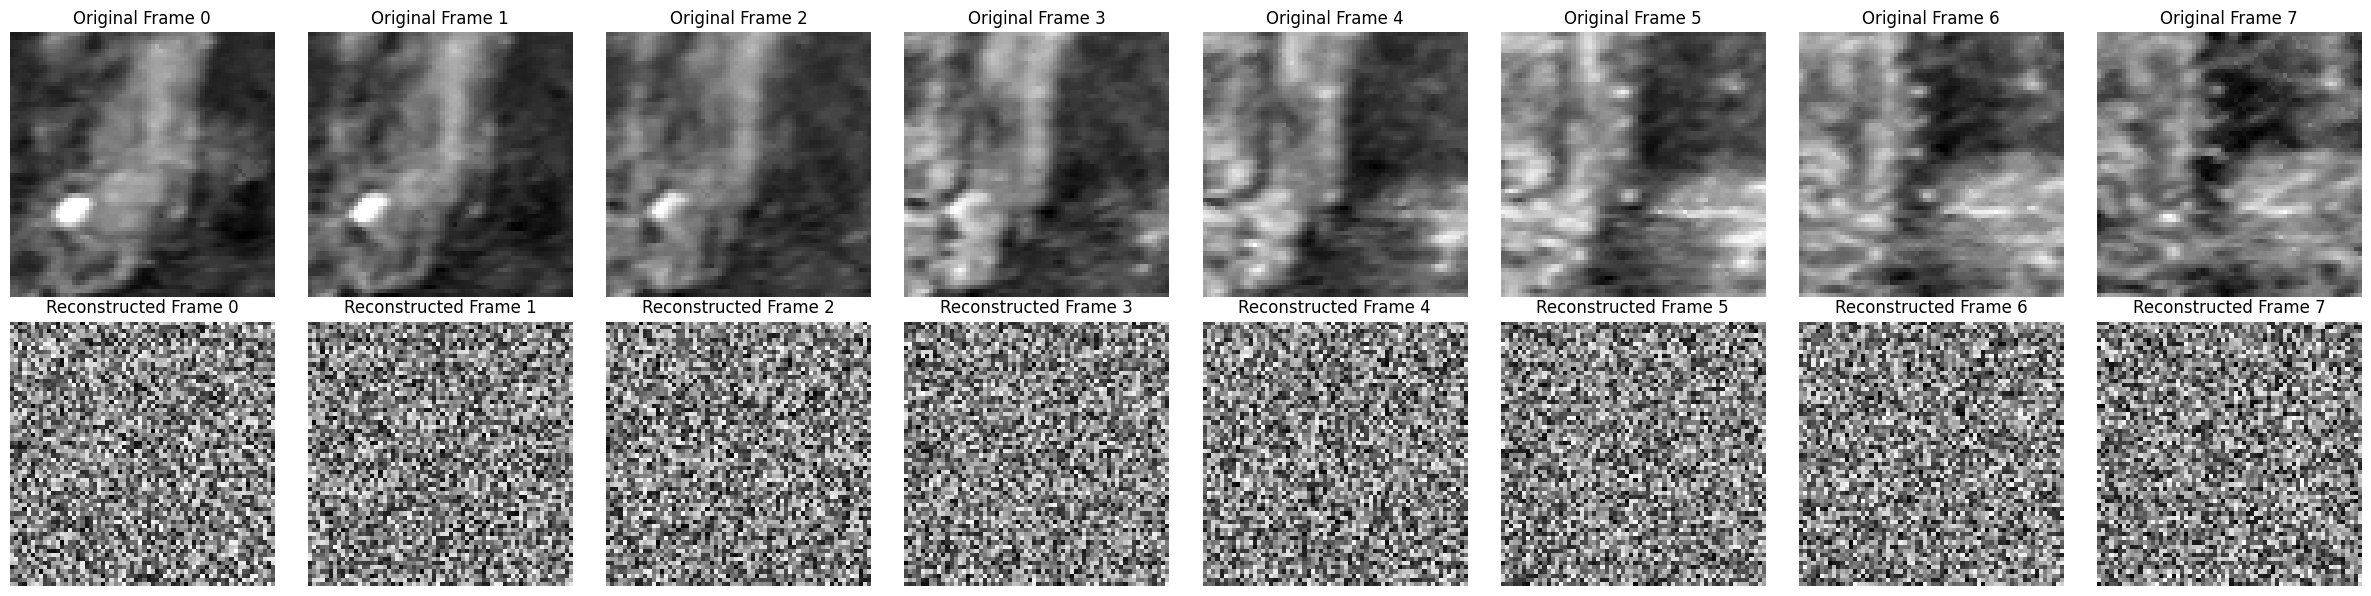

/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 11:   0%|          | 0/4 [00:00<?, ?it/s, v_num=26, train_loss=0.0667, lr=2e-5]          

/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:990: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 99: 100%|██████████| 4/4 [00:01<00:00,  2.61it/s, v_num=26, train_loss=0.0486, lr=1.96e-5]

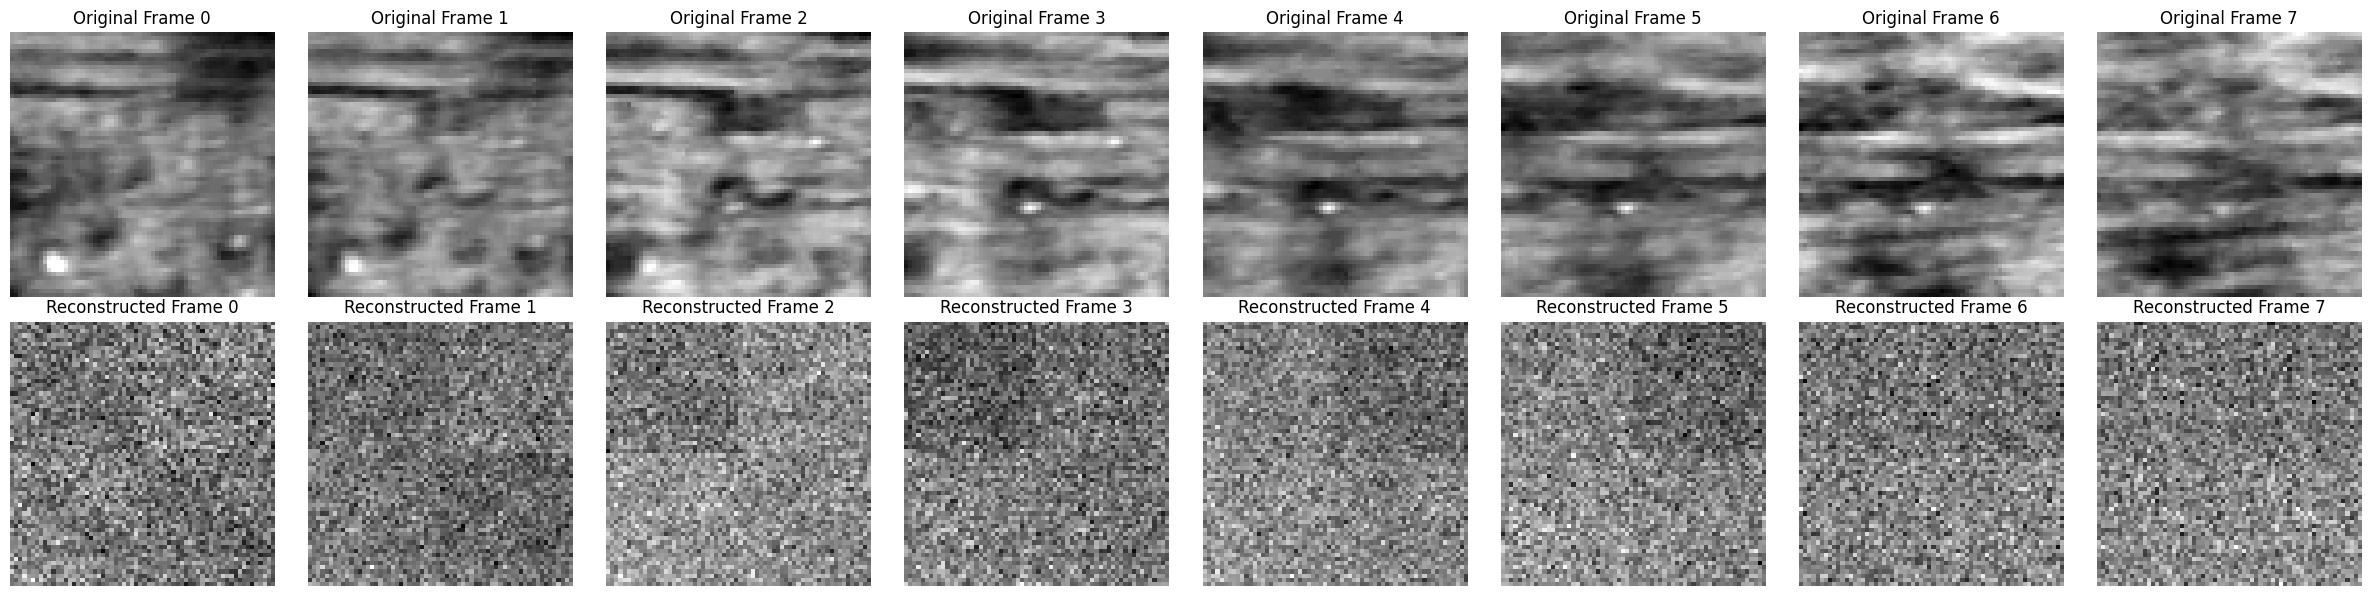

Epoch 127:  75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s, v_num=26, train_loss=0.0487, lr=1.93e-5, val_loss=0.0452]


Detected KeyboardInterrupt, attempting graceful shutdown ...


Epoch 4:  25%|██▌       | 1/4 [5:16:43<15:50:11,  0.00it/s, v_num=25, train_loss=0.241, lr=8e-6]


NameError: name 'exit' is not defined

In [118]:
import math
from torch.optim import AdamW
from warmup_scheduler import GradualWarmupScheduler
from transformers import SegformerForSemanticSegmentation
from torchvision.models.video import swin_transformer
import albumentations as A
from transformers import AutoImageProcessor, TimesformerModel
from transformers import TimesformerModel, TimesformerConfig
import numpy as np

class MAEPretrain(pl.LightningModule):
    def __init__(self, lr=1e-4, mask_ratio=0.75, embed_dim=768, decoder_dim=512, decoder_layers=4):
        super().__init__()
        self.save_hyperparameters()
        
    
        # self.encoder  = swin_transformer.swin3d_t(weights="KINETICS400_V1") #KINETICS400_IMAGENET22K_V1
        # backbone = swin_transformer.swin3d_b(weights='KINETICS400_V1') #KINETICS400_IMAGENET22K_V1
        # Load pretrained Swin3D backbone
        # backbone = swin_transformer.swin3d_s(weights='KINETICS400_V1')
        backbone = swin_transformer.SwinTransformer3d(
            patch_size=[2, 4, 4],      # temporal=2, spatial=4x4 patches
            embed_dim=96,              # base dimension
            depths=[2, 2, 12, 2],       # Tiny config
            num_heads=[3, 6, 12, 24],  # heads per stage
            window_size=[8, 7, 7],     # attention window
            stochastic_depth_prob=0.1, # DropPath
        )

        # Get old weights
        old_conv = backbone.patch_embed.proj  # Conv3d(3, 128, ...)
        weight = old_conv.weight  # [128, 3, 2, 4, 4]
        bias = old_conv.bias      # [128]

        # Adapt weights: average across RGB → 1 channel
        new_weight = weight.sum(dim=1, keepdim=True)  # [128, 1, 2, 4, 4]

        # Replace conv with new one (keep out_channels=128!)
        backbone.patch_embed.proj = nn.Conv3d(
            in_channels=1,
            out_channels=128,
            kernel_size=(2, 4, 4),
            stride=(2, 4, 4),
            bias=True
        )

        # Load adapted weights
        backbone.patch_embed.proj.weight = nn.Parameter(new_weight)
        backbone.patch_embed.proj.bias = nn.Parameter(bias.clone())  # shape [128]
        self.encoder = nn.Sequential(*list(backbone.children())[:-2]) 
        
        self.patch_size = 32
        self.input_T = 16
        self.input_H = 64
        self.input_W = 64
        self.tubelet_size = 2
        self.mask_ratio = self.hparams.mask_ratio
        mse_loss = nn.MSELoss()
        l1_loss = nn.L1Loss()

        self.criterion = lambda pred, target: 1 * mse_loss(pred, target) #+ 0.5 * l1_loss(pred, target)        
        
        # self.N = self.input_T * self.input_H * self.input_W // (self.patch_size**2*2)
        self.N = (self.input_T // self.tubelet_size) * \
         (self.input_H // self.patch_size) * \
         (self.input_W // self.patch_size)
        print(f"Total patches: {self.N}")

        self.unmasked_patches =  int((1- self.mask_ratio)* self.input_T/self.tubelet_size)* self.input_H//self.patch_size* self.input_W//self.patch_size
        print(f"Actual patches used: {self.unmasked_patches}/{self.N} : {self.unmasked_patches/self.N:.2f}")

        # Transformer decoder components
        self.decoder_embed = nn.Linear(embed_dim, decoder_dim)
        self.decoder_pos_embed = nn.Parameter(torch.randn(1, self.N, decoder_dim))
        
        decoder_layer = nn.TransformerEncoderLayer(d_model=decoder_dim, nhead=8, dim_feedforward=decoder_dim, batch_first=True)
        self.decoder_transformer = nn.TransformerEncoder(decoder_layer, num_layers=decoder_layers)
        self.decoder_pred = nn.Sequential(
            nn.Linear(decoder_dim, self.patch_size**2*self.tubelet_size),
            nn.Tanh()
        )

        # Mask token for masked patches in decoder
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_dim))
        nn.init.normal_(self.mask_token, std=0.02)
        
    def patchify(self, x):
        """
        x: (B, T, C, H, W)
        Returns:
            patches: (B, N, patch_dim)
            where N = (T//tubelet_size) * (H//patch_size) * (W//patch_size)
                    patch_dim = C * tubelet_size * patch_size * patch_size
        """
        B, T, C, H, W = x.shape
        tubelet = self.tubelet_size   # e.g., 2
        ps = self.patch_size          # e.g., 32

        # (B, T, C, H, W) → (B, C, T, H, W)
        x = x.permute(0, 2, 1, 3, 4)
        
        # Unfold temporal and spatial dims
        x = x.unfold(2, tubelet, tubelet) \
            .unfold(3, ps, ps) \
            .unfold(4, ps, ps)
        # shape: (B, C, T_patches, H_patches, W_patches, tubelet, ps, ps)

        T_patches = x.size(2)
        H_patches = x.size(3)
        W_patches = x.size(4)

        # Reorder: (B, T_p, H_p, W_p, tubelet, ps, ps, C)
        x = x.permute(0, 2, 3, 4, 5, 6, 7, 1)

        # Flatten each patch: (B, N, C * tubelet * ps * ps)
        x = x.reshape(B, T_patches * H_patches * W_patches,
                    C * tubelet * ps * ps)
        # print(x.shape)
        return x

    def unpatchify(self, x, patch_shape):
        # x: (B, N, D)
        B, N, D = x.shape
        pt, ph, pw = patch_shape
        ps = self.patch_size
        tubelet = self.tubelet_size
        C = 1
        assert ph * pw * pt == N, "Patch count mismatch"
        x = x.view(B, pt, ph, pw, C, tubelet, ps, ps)                  # (..., C, tubelet, ps, ps)
        x = x.permute(0, 4, 1, 5, 2, 6, 3, 7).contiguous()             # (B, C, pt, tubelet, ph, ps, pw, ps)
        x = x.view(B, C, pt * tubelet, ph * ps, pw * ps)               # (B, C, T, H, W)
        return x
    
    def frame_masking(self, x, mask_ratio=0.75):
        """
        Frame-level masking applied to patchified input.
        x: (B, N, D) where 
        N = (T//tubelet) * (H//ps) * (W//ps)
        Returns:
            x_masked:   (B, n_keep*H_p*W_p, D)
            ids_keep:   (B, n_keep*H_p*W_p)
            ids_masked: (B, n_mask*H_p*W_p)
            ids_restore:(B, N)  - to restore original order
        """
        B, N, D = x.shape
        T_groups = self.input_T // self.tubelet_size   # e.g., 4
        H_groups = self.input_H // self.patch_size     # e.g., 7
        W_groups = self.input_W // self.patch_size     # e.g., 7
        # print(T_groups,H_groups,W_groups)
        # print(N)
        patches_per_frame = H_groups * W_groups
        assert N == T_groups * patches_per_frame, "Patch count mismatch"

        n_keep_frames = int((1 - mask_ratio) * T_groups)
        n_keep = n_keep_frames * patches_per_frame

        ids_keep, ids_masked, ids_restore = [], [], []

        for b in range(B):
            # permute frames
            perm_frames = torch.randperm(T_groups, device=x.device)
            keep_frames = perm_frames[:n_keep_frames]
            mask_frames = perm_frames[n_keep_frames:]

            # expand to patch indices
            keep_idx = (keep_frames[:, None] * patches_per_frame +
                        torch.arange(patches_per_frame, device=x.device)[None, :])
            mask_idx = (mask_frames[:, None] * patches_per_frame +
                        torch.arange(patches_per_frame, device=x.device)[None, :])

            keep_idx = keep_idx.flatten()
            mask_idx = mask_idx.flatten()

            # build restore index
            perm = torch.cat([keep_idx, mask_idx], dim=0)
            ids_restore_b = torch.empty_like(perm)
            ids_restore_b[perm] = torch.arange(N, device=x.device)

            ids_keep.append(keep_idx)
            ids_masked.append(mask_idx)
            ids_restore.append(ids_restore_b)

        ids_keep = torch.stack(ids_keep, dim=0)      # (B, n_keep)
        ids_masked = torch.stack(ids_masked, dim=0)  # (B, n_mask)
        ids_restore = torch.stack(ids_restore, dim=0) # (B, N)

        # gather visible patches
        x_masked = torch.gather(x, 1, ids_keep.unsqueeze(-1).expand(-1, -1, D))

        return x_masked, ids_keep, ids_masked, ids_restore

    def tube_masking(self, x, mask_ratio=0.75):
        """
        Tube-level masking applied to patchified input.
        x: (B, N, D) where 
            N = (T//tubelet) * (H//ps) * (W//ps)
        Returns:
            x_masked:   (B, n_keep*D)
            ids_keep:   (B, n_keep)
            ids_masked: (B, n_mask)
            ids_restore:(B, N)  - to restore original order
        """
        B, N, D = x.shape
        T_groups = self.input_T // self.tubelet_size   # temporal groups
        H_groups = self.input_H // self.patch_size     # spatial groups (height)
        W_groups = self.input_W // self.patch_size     # spatial groups (width)

        num_tubes = H_groups * W_groups  # number of spatial tube locations
        tube_len = T_groups              # length of each tube (temporal depth)

        # # each "tube" corresponds to all temporal positions at one (h, w)
        assert N == num_tubes * tube_len, "Patch count mismatch"

        n_keep_tubes = self.N - self.unmasked_patches

        ids_keep, ids_masked, ids_restore = [], [], []

        for b in range(B):
            # permute tube positions
            perm_tubes = torch.randperm(num_tubes, device=x.device)
            keep_tubes = perm_tubes[:n_keep_tubes]
            mask_tubes = perm_tubes[n_keep_tubes:]

            # expand tube indices across time
            keep_idx = (keep_tubes[:, None] * tube_len +
                        torch.arange(tube_len, device=x.device)[None, :])
            mask_idx = (mask_tubes[:, None] * tube_len +
                        torch.arange(tube_len, device=x.device)[None, :])

            keep_idx = keep_idx.flatten()
            mask_idx = mask_idx.flatten()

            # build restore index
            perm = torch.cat([keep_idx, mask_idx], dim=0)
            ids_restore_b = torch.empty_like(perm)
            ids_restore_b[perm] = torch.arange(N, device=x.device)

            ids_keep.append(keep_idx)
            ids_masked.append(mask_idx)
            ids_restore.append(ids_restore_b)

        ids_keep = torch.stack(ids_keep, dim=0)      # (B, n_keep)
        ids_masked = torch.stack(ids_masked, dim=0)  # (B, n_mask)
        ids_restore = torch.stack(ids_restore, dim=0) # (B, N)

        # gather visible patches
        x_masked = torch.gather(x, 1, ids_keep.unsqueeze(-1).expand(-1, -1, D))

        return x_masked, ids_keep, ids_masked, ids_restore


    def random_masking(self, x, mask_ratio=0.75):
        """
        MAE-style random masking with restore indices.
        x: (B, N, D)
        Returns:
            x_masked: (B, n_keep, D)    - visible patches
            ids_keep: (B, n_keep)       - indices of kept patches
            ids_masked: (B, n_mask)     - indices of masked patches
            ids_restore: (B, N)         - to restore original order
        """
        B, N, D = x.shape
        n_keep = self.unmasked_patches

        ids_keep = []
        ids_masked = []
        ids_restore = []

        for b in range(B):
            # 1. Random permutation of all patches
            perm = torch.randperm(N, device=x.device)
            keep = perm[:n_keep]
            masked = perm[n_keep:]

            # 2. Save indices
            ids_keep.append(keep)
            ids_masked.append(masked)

            # 3. Build restore index (inverse of permutation)
            ids_restore_b = torch.empty_like(perm)
            ids_restore_b[perm] = torch.arange(N, device=x.device)
            ids_restore.append(ids_restore_b)

        ids_keep = torch.stack(ids_keep, dim=0)      # (B, n_keep)
        ids_masked = torch.stack(ids_masked, dim=0)  # (B, n_mask)
        ids_restore = torch.stack(ids_restore, dim=0) # (B, N)

        # 4. Gather kept tokens
        x_masked = torch.gather(x, 1, ids_keep.unsqueeze(-1).expand(-1, -1, D))

        return x_masked, ids_keep, ids_masked, ids_restore
    

    def forward(self, x):
        B, T, C, H, W = x.shape # (B, T, C, H, W)

        # print(x.shape)
        # 1. Patchify input video
        x_patched = self.patchify(x)  # (B, N, D)
        # print('x_patched',x_patched.shape) # (B,N,T,D)
        
        N = x_patched.shape[1]

        # 2. Mask patches
        x_masked, ids_keep, ids_masked, ids_restore = self.frame_masking(x_patched, self.mask_ratio)
        
        # print('x_masked',x_masked.shape) # (B,N,T,D)
        ids_keep = ids_keep.long() # Ids of unmasked
        ids_masked = ids_masked.long()
        ids_restore = ids_restore.long()

        # Calculate masked patch indices
        all_ids = torch.arange(N, device=x.device).unsqueeze(0).expand(B, -1)  # (B, N)
        mask = torch.ones_like(all_ids, dtype=torch.bool)
        mask.scatter_(1, ids_keep, False)
        
        pt = int((self.input_T // self.tubelet_size)*(1-self.mask_ratio))
        ph = pw = int((self.unmasked_patches // pt) ** 0.5)
        assert ph * pw * pt == self.unmasked_patches, "Patch grid mismatch"

        # We know the tube shape is (pt, square_size, square_size)
        x_masked_video = self.unpatchify(x_masked, (pt, ph, pw))  # (B, C, T, H_mask, W_mask)
        # print('x_masked_unpatchify',x_masked_video.shape)
        
        # 4. Encoder forward on masked video        
        # x_masked_video = x_masked_video.permute(0,2,1,3,4) # (B,T,C,H,W)
        outputs = self.encoder(x_masked_video)
        # print('outputs',outputs.shape)
        # Group first
        tokens = outputs#.view(B, pt, ph, pw, self.hparams.embed_dim)  # (B, 16, 8, 8, D)
        # tokens = tokens.view(B, ph, pw, T, self.hparams.embed_dim)  # (B, 16, 8, 8, D)
        # tokens = tokens.permute(0, 3, 1, 2, 4).contiguous()         # (B, ph, pw, T, D)  <-- matches your compact cube order
        # print(tokens.shape)

        # 5. Embed encoder features to decoder_dim
        x_vis = self.decoder_embed(tokens)  # (B, n_visible, decoder_dim)
        
        x_vis = x_vis.view(B,-1,self.hparams.decoder_dim)
        # print(x_vis.shape)

        # 6. Prepare mask tokens for masked patches
        # print(ids_masked.shape[1])

        mask_tokens = self.mask_token.expand(B, ids_masked.shape[1], -1)  # (B, n_masked, decoder_dim)
        # x_ = torch.cat([x_vis, mask_tokens], dim=1)   # (B, N, D) but shuffled
        # x_dec = torch.gather(x_, 1, ids_restore.unsqueeze(-1).expand(-1, -1, x_vis.shape[2]))

        # print(mask_tokens.shape)
        # 7. Create full sequence tensor for decoder input
        # Restore to original order
        x_ = torch.cat([x_vis, mask_tokens], dim=1)  # (B, n_keep + n_masked, D)
        # print(x.shape)
        x_dec = torch.gather(x_, 1, ids_restore.unsqueeze(-1).expand(-1, -1, x_.shape[2]))

        # 8. Add positional embedding
        x_dec = x_dec + self.decoder_pos_embed
    
        # 9. Decode full sequence
        x_dec = self.decoder_transformer(x_dec)
        # print('x_dec',x_dec.shape)
        pred = self.decoder_pred(x_dec)  # (B, N, patch_dim)
        
        # 3. Unpatchify visible patches to video for encoder
        pt = self.input_T // self.tubelet_size
        ph = pw = int((self.N // pt) ** 0.5)
        # print(pt,ph,pw)
        # 
        recon = self.unpatchify(pred, (pt, ph, pw))  # (B, C, T, H, W)
        recon = recon.permute(0, 2, 1, 3, 4)  # (B, T, C, H, W)
        # print(recon.shape)
        return recon, x_masked_video, mask, ids_masked, pred, x_patched

    def training_step(self, batch, batch_idx):
        x, y = batch  # (B, 1, T, H, W)
        B = x.shape[0]

        recon, x_masked, mask, ids_masked, pred, target = self(x)

        # Gather masked predictions & targets per device
        B, N, D = pred.shape
        device = pred.device

        # ids_masked: (B, n_mask)
        ids_masked_exp = ids_masked.unsqueeze(-1).expand(-1, -1, D)  # (B, n_mask, D)

        pred_masked   = torch.gather(pred,   1, ids_masked_exp)  # (B, n_mask, D)
        target_masked = torch.gather(target, 1, ids_masked_exp)  # (B, n_mask, D)

        # Compute loss only on masked patches
        loss = self.criterion(pred_masked, target_masked)
        self.log("train_loss", loss, prog_bar=True, logger=True, sync_dist=True)  # sync across devices
        self.log("lr", self.optimizers().param_groups[0]['lr'], prog_bar=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        recon, _, mask, _, _, _ = self(x)
        loss = self.criterion(recon, x)
        self.log('val_loss', loss, prog_bar=True)
        # Save first batch to visualize later
        if batch_idx == 0:
            self.val_batch_for_viz = (x, mask, recon)
        return loss

    def on_validation_epoch_end(self):
        if hasattr(self, 'val_batch_for_viz'):
            x, mask, recon = self.val_batch_for_viz
            visualize_reconstruction(x, recon, sample_idx=0, num_frames=8)
            
    def configure_optimizers(self):
        optimizer = AdamW([
            {'params': self.encoder.parameters(), 'lr': 2e-5, 'weight_decay': 1e-7},
            {'params': list(self.decoder_embed.parameters()) +
                    list(self.decoder_transformer.parameters()) +
                    list(self.decoder_pred.parameters()), 
            'lr': 1e-4, 'weight_decay': 1e-7}
        ])

        # Cosine LR with warmup
        cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)
        scheduler = GradualWarmupScheduler(
            optimizer, multiplier=1, total_epoch=10, after_scheduler=cosine_scheduler
        )

        return [optimizer], [scheduler]



model = MAEPretrain()
trainer = pl.Trainer(
    max_epochs=1000,
    accelerator='auto',
    log_every_n_steps=20,
    check_val_every_n_epoch=100,
)
trainer.fit(model, train_loader, train_loader)

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TokenPerPixelDecoder(nn.Module):
    def __init__(self, embed_dim=96, patch_size=4, num_heads=3, depth=4):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch_size = patch_size  # size of sub-patch (e.g., 4x4)
        self.decoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim*4,
            dropout=0.1,
            activation="gelu",
            batch_first=True
        )
        self.decoder = nn.TransformerEncoder(self.decoder_layer, num_layers=depth)
        # Map each token back to pixels in sub-patch
        self.token_to_pixel = nn.Linear(embed_dim, 1)

    def forward(self, feats):
        """
        feats: (B, C, H, W)
        """
        B, C, H, W = feats.shape
        print(feats.shape)

        # 1️⃣ Split HxW into non-overlapping patches of size patch_size
        ph, pw = 2,2
        assert H % ph == 0 and W % pw == 0, "H and W must be divisible by patch_size"
        Hf, Wf = H // ph, W // pw

        # Reshape: (B, C, Hf, ph, Wf, pw) → (B, Hf*Wf, C, ph*pw)
        patches = feats.unfold(2, ph, ph).unfold(3, pw, pw)  # (B, C, Hf, Wf, ph, pw)
        print( patches.shape)
        patches = patches.contiguous().view(B, C, Hf*Wf, ph*pw).permute(0, 2, 3, 1)  # (B, N_patches, ph*pw, C)
        print( patches.shape)
        # Flatten sub-patches into tokens: each pixel becomes a token
        tokens = patches.view(B, Hf*Wf*ph*pw, C)  # (B, N_tokens, embed_dim)
        print( tokens.shape)
        # 2️⃣ Transformer decoder
        tokens = self.decoder(tokens)  # (B, N_tokens, embed_dim)
        print( tokens.shape)
        # 3️⃣ Map tokens back to pixel intensities
        pixels = self.token_to_pixel(tokens)  # (B, N_tokens, patch_size^2)
        print( pixels.shape)
        print(Hf,Wf,ph,pw)
        pixels = pixels.view(B, Hf, Wf, ph, pw)  # (B, Hf, Wf, ph, pw)
        pixels = pixels.permute(0, 1, 3, 2, 4).contiguous().view(B, H, W)  # (B, H, W)

        return pixels.unsqueeze(1)  # (B, 1, H, W) reconstructed

# Example usage:
B, C, H, W = 2, 96, 64, 64
x = torch.randn(B, C, H, W)
decoder = TokenPerPixelDecoder(embed_dim=96, patch_size=4)
out = decoder(x)
print(out.shape)  # (2, 1, 64, 64)


torch.Size([2, 96, 64, 64])
torch.Size([2, 96, 32, 32, 2, 2])
torch.Size([2, 1024, 4, 96])
torch.Size([2, 4096, 96])
torch.Size([2, 4096, 96])
torch.Size([2, 4096, 1])
32 32 2 2
torch.Size([2, 1, 64, 64])


In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.video import swin_transformer

class TokenPerVoxelDecoder3D(nn.Module):
    def __init__(self, embed_dim=32, patch_size=16, num_heads=4, depth=4):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        backbone = swin_transformer.swin3d_t(weights=None)  # or pretrained weights
        self.proj = nn.Linear(768, self.embed_dim)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2]) 
        self.decoder_layer = nn.TransformerEncoderLayer(
            d_model=12,
            nhead=num_heads,
            dim_feedforward=embed_dim*4,
            dropout=0.1,
            activation="gelu",
            batch_first=True
        )
        self.pos_embed = nn.Parameter(torch.zeros(1, 2*2*64, 12))
        self.decoder = nn.TransformerEncoder(self.decoder_layer, num_layers=depth)
        self.token_to_voxel = nn.Linear(12, 1)  # output 1 intensity per voxel

    def forward(self, x):
        """
        x: (B, C, D, H, W)
        """
        B, C, D, H, W = x.shape

        # Backbone features
        feats = self.backbone(x)  # (B, embed_dim, D', H', W')
        feats = feats.mean(dim=1) # (B, 1, Hf, Wf, embed_dim,)
        print(feats.shape)
        _,  Hf, Wf,C_feat = feats.shape

        # Split into sub-patches
        pd, ph, pw = 1,2,2
        assert Hf % ph == 0 and Wf % pw == 0

        Dp, Hp, Wp = 0, Hf // ph, Wf // pw
        # pixels = self.proj(feats)  # (B, D', H', W', 4)
        
        print(feats.shape,'pixls')
        # Unfold into patches
        # feats = feats.permute(0,3,1, 2)  # (B,C,Df,Hf,Wf)
        # print(feats.shape)
        # patches = feats.unfold(2, ph, ph).unfold(3, pw, pw)  # (B,C,Dp,Hp,Wp,pd,ph,pw)
        # patches = patches.contiguous().view(B, C_feat, Hp*Wp, ph*pw).permute(0,2,3,1)  # (B,N_patches,patch_size^3,C)
        # print('patchs',patches.shape)
        # Flatten each voxel in patch → token
        # tokens = patches.view(B, Hp*Wp*ph*pw, C_feat)  # (B, N_tokens, embed_dim)
        # print('tokens',tokens.shape)
        # Transformer decoder
        pixels = feats.view(B,ph*pw*64,12)
        print('pixels before decoder',pixels.shape)
         # Add positional embedding
        pixels = pixels + self.pos_embed

        tokens = self.decoder(pixels)
        print('tokens after decoder',tokens.shape)

        # Map tokens → voxel intensities
        voxels = self.token_to_voxel(tokens)  # (B, N_tokens, 1)
        voxels = voxels.view(B,2,2,8,8)  # (B, Dp, Hp, Wp, pd, ph, pw)
        voxels = voxels.permute(0,1,3,2,4).contiguous().view(B,1,16,16)  # reconstructed 3D
        # voxels = voxels.view(B,  Hp, Wp, pd, ph, pw)  # (B,Dp,Hp,Wp,pd,ph,pw)
        # voxels = voxels.permute(0,1,4,2,5,3,6).contiguous().view(B,1,Hf,Wf)  # reconstructed 3D

        return voxels

# Example usage
x = torch.randn(2,3,16,64,64)
decoder = TokenPerVoxelDecoder3D(embed_dim=64, patch_size=32)
out = decoder(x)
print(out.shape)  # (2,1,D',H',W')


torch.Size([2, 2, 2, 768])
torch.Size([2, 2, 2, 768]) pixls
pixels before decoder torch.Size([2, 256, 12])
tokens after decoder torch.Size([2, 256, 12])
torch.Size([2, 1, 16, 16])


In [ ]:
from torchvision.models.video import swin_transformer

backbone = swin_transformer.SwinTransformer3d(
    patch_size=[2, 4, 4],      # temporal=2, spatial=4x4 patches
    embed_dim=96,              # base dimension
    depths=[2, 2, 12, 2],       # Tiny config
    num_heads=[3, 6, 12, 24],  # heads per stage
    window_size=[8, 7, 7],     # attention window
    stochastic_depth_prob=0.1, # DropPath
)

x = torch.randn(2,3,16,64,64)
backbone = nn.Sequential(*list(backbone.children())[:-2])
out = backbone(x)
out.shape

torch.Size([2, 8, 2, 2, 768])

In [10]:
import torch
import torch.nn as nn
from torchvision.models.video import swin_transformer


# class Swin3DEncoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         backbone = swin_transformer.swin3d_t(weights='KINETICS400_V1')
#                 # Get old weights
#         old_conv = backbone.patch_embed.proj  # Conv3d(3, 128, ...)
#         weight = old_conv.weight  # [128, 3, 2, 4, 4]
#         bias = old_conv.bias      # [128]

#         # Adapt weights: average across RGB → 1 channel
#         new_weight = weight.sum(dim=1, keepdim=True)  # [128, 1, 2, 4, 4]

#         # Replace conv with new one (keep out_channels=128!)
#         backbone.patch_embed.proj = nn.Conv3d(
#             in_channels=1,
#             out_channels=128,
#             kernel_size=(2, 4, 4),
#             stride=(2, 4, 4),
#             bias=True
#         )

#         # # Load adapted weights
#         backbone.patch_embed.proj.weight = nn.Parameter(new_weight)
#         backbone.patch_embed.proj.bias = nn.Parameter(bias.clone())  # shape [128]
#         backbone = nn.Sequential(*list(backbone.children())[:-2]) 

#         # ckpt_path = "pretraining/checkpoints/64_tiny_16_epoch=16.ckpt"
#         ckpt_path = "pretraining/checkpoints/64_tiny_16_scratch_epoch=17.ckpt"
#         ckpt = torch.load(ckpt_path, map_location='cpu',weights_only=False)  # CPU first, move to GPU later if needed

#         # Check if it's a Lightning checkpoint
#         if 'state_dict' in ckpt:
#             state_dict = ckpt['state_dict']
#         else:
#             state_dict = ckpt
#                 # Filter only encoder weights (keys start with 'encoder.')
#         encoder_state_dict = {}
#         for k, v in state_dict.items():
#             if k.startswith('encoder.'):
#                 # remove 'encoder.' prefix to match backbone keys
#                 encoder_state_dict[k.replace('encoder.', '')] = v

#         missing, unexpected =  backbone.load_state_dict(encoder_state_dict, strict=False)
#         print("Missing keys:", missing)
#         print("Unexpected keys:", unexpected)
#         self.backbone = backbone


#     def forward(self, x):
#         x = self.backbone.patch_embed(x)   # (B, T/2, H/4, W/4, 96)
#         x = self.backbone.pos_drop(x)

#         skips = []
#         # backbone.features = [stage0, PatchMerging, stage1, PatchMerging, stage2, PatchMerging, stage3]
#         for i, block in enumerate(self.backbone.features):
#             x = block(x)
#             if isinstance(block, nn.Sequential):  # stage output
#                 skips.append(x)

#         return skips  # [s1, s2, s3, s4]

class Swin3DEncoder(nn.Module):
    def __init__(self, pretrained_ckpt='pretraining/checkpoints/64_tiny_16_epoch=16.ckpt', in_chans=1):
        super().__init__()
        # Load Swin3D
        self.backbone = swin_transformer.swin3d_t(weights=None)

        # --- patch_embed adaptation for 1 channel ---
        old_conv = self.backbone.patch_embed.proj
        weight = old_conv.weight.sum(dim=1, keepdim=True)  # [128, 1, 2, 4, 4]
        bias = old_conv.bias

        self.backbone.patch_embed.proj = nn.Conv3d(
            in_channels=in_chans,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            bias=True
        )
        self.backbone.patch_embed.proj.weight = nn.Parameter(weight)
        self.backbone.patch_embed.proj.bias = nn.Parameter(bias.clone())

        # remove classifier head, keep norm
        self.backbone.head = nn.Identity()
        self.backbone.avgpool = nn.Identity()

        # optionally load ckpt
        if pretrained_ckpt:
            ckpt = torch.load(pretrained_ckpt, map_location='cpu',weights_only=False)
            ckpt_state_dict = ckpt['state_dict']  # your loaded checkpoint
            model_state_dict = self.backbone.state_dict()

            new_state_dict = {}
            used_ckpt_keys = set()  # keep track of keys already used


            for k_model in model_state_dict.keys():
                # Skip decoder stuff
                if any(x in k_model for x in ['decoder_pos_embed', 'mask_token', 'decoder']):
                    continue
                print(k_model)
                # Find corresponding key in checkpoint
                if k_model in ckpt_state_dict:
                    new_state_dict[k_model] = ckpt_state_dict[k_model]
                else:
                    # Fallback: find first unused key with matching shape
                    for k_ckpt, v_ckpt in ckpt_state_dict.items():
                        if k_ckpt in used_ckpt_keys:
                            continue  # skip already used keys
                        if v_ckpt.shape == model_state_dict[k_model].shape:
                            new_state_dict[k_model] = v_ckpt
                            used_ckpt_keys.add(k_ckpt)
                            print(f"Fallback match: {k_model} <- {k_ckpt}")
                            break
                            
            # Load into model
            msg = self.backbone.load_state_dict(new_state_dict, strict=False)
            print("Loaded:", msg)

    def forward(self, x):
        x = self.backbone.patch_embed(x)   # (B, T/2, H/4, W/4, 96)
        x = self.backbone.pos_drop(x)

        skips = []
        # backbone.features = [stage0, PatchMerging, stage1, PatchMerging, stage2, PatchMerging, stage3]
        for i, block in enumerate(self.backbone.features):
            x = block(x)
            if isinstance(block, nn.Sequential):  # stage output
                skips.append(x)

        return skips  # [s1, s2, s3, s4]

# # ---------------- Decoder Blocks ---------------- #
# class UpBlock3D(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.up = nn.ConvTranspose3d(in_ch, out_ch, kernel_size=2, stride=2)
#         self.conv = nn.Sequential(
#             nn.Conv3d(out_ch * 2, out_ch, kernel_size=3, padding=1),
#             nn.BatchNorm3d(out_ch),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
#             nn.BatchNorm3d(out_ch),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x, skip):
#         x = self.up(x)
#         # Match skip size
#         if x.shape[2:] != skip.shape[2:]:
#             diff = [s - d for s, d in zip(skip.shape[2:], x.shape[2:])]
#             x = nn.functional.pad(x, [0, diff[2], 0, diff[1], 0, diff[0]])
#         x = torch.cat([x, skip], dim=1)
#         return self.conv(x)
class UpBlock2D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch * 2, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, skip):
        # squeeze away the temporal dim if present
        if x.dim() == 5:  # (B, C, 1, H, W)
            x = x.squeeze(2)
        if skip.dim() == 5:
            skip = skip.squeeze(2)

        x = self.up(x)

        # pad if needed
        if x.shape[2:] != skip.shape[2:]:
            diff = [s - d for s, d in zip(skip.shape[2:], x.shape[2:])]
            x = nn.functional.pad(x, [0, diff[1], 0, diff[0]])

        x = torch.cat([x, skip], dim=1)
        return self.conv(x)


# ---------------- Full UNet ---------------- #
class SwinUNet3D(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.encoder = Swin3DEncoder()

        # Channels per stage (tiny config)
        self.enc_channels = [96, 192, 384, 768]

        # Bottleneck conv to reshape final feature
        self.bottleneck = nn.Conv3d(self.enc_channels[-1], 768, kernel_size=1)

        # Decoder (reverse order)
        self.up3 = UpBlock2D(768, 384)
        self.up2 = UpBlock2D(384, 192)
        self.up1 = UpBlock2D(192, 96)

        # Final segmentation head
        self.head = nn.Conv2d(96, 1, kernel_size=1)

    def forward(self, x):
        # get swin feature maps [s1, s2, s3, s4]
        feat_maps = self.encoder(x)

        # convert to (B, C, T, H, W)
        feat_maps = [f.permute(0, 4, 1, 2, 3).contiguous() for f in feat_maps]

        # temporal max pooling -> (B, C, 1, H, W)
        s1, s2, s3, s4 = [torch.max(f, dim=2, keepdim=True)[0] for f in feat_maps]

        # bottleneck on last stage
        x = self.bottleneck(s4)
        x = x.max(dim=2, keepdim=True)[0]  # squash temporal

        # decoder path (2D upsampling blocks)
        x = self.up3(x, s3)
        print(x.shape)
        x = self.up2(x, s2)
        print(x.shape)
        x = self.up1(x, s1)
        print(x.shape)

        out = self.head(x)  # still (B, 1, 1, H, W)

        # squeeze away the dummy temporal dim → pure 2D
        out = out.squeeze(2)  # (B, 1, H, W)

        return out


# ---------------- Test Run ---------------- #
if __name__ == "__main__":
    x = torch.randn(2, 1, 16, 224, 224)  # (B, C, T, H, W)
    model = SwinUNet3D(num_classes=1)
    out = model(x)
    print("Output shape:", out.shape)


patch_embed.proj.weight
Fallback match: patch_embed.proj.weight <- encoder.0.proj.weight
patch_embed.proj.bias
Fallback match: patch_embed.proj.bias <- encoder.0.proj.bias
patch_embed.norm.weight
Fallback match: patch_embed.norm.weight <- encoder.0.norm.weight
patch_embed.norm.bias
Fallback match: patch_embed.norm.bias <- encoder.0.norm.bias
features.0.0.norm1.weight
Fallback match: features.0.0.norm1.weight <- encoder.2.0.0.norm1.weight
features.0.0.norm1.bias
Fallback match: features.0.0.norm1.bias <- encoder.2.0.0.norm1.bias
features.0.0.attn.relative_position_bias_table
Fallback match: features.0.0.attn.relative_position_bias_table <- encoder.2.0.0.attn.relative_position_bias_table
features.0.0.attn.relative_position_index
Fallback match: features.0.0.attn.relative_position_index <- encoder.2.0.0.attn.relative_position_index
features.0.0.attn.qkv.weight
Fallback match: features.0.0.attn.qkv.weight <- encoder.2.0.0.attn.qkv.weight
features.0.0.attn.qkv.bias
Fallback match: features.

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.video import swin_transformer

# ---------------- 3D PatchExpansion ---------------- #
class PatchExpansion3D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim_in = dim
        self.expand = nn.Linear(dim, dim * 8, bias=False)  # expand for 2x2x2
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        # x: (B, T, H, W, C)
        B, T, H, W, C = x.shape
        x = self.expand(x)  # (B, T, H, W, 8*C)
        x = x.view(B, T, H, W, 2, 2, 2, C)  # split for 2x upsampling
        x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous()  # reorder to (B, T, 2, H, 2, W, 2, C)
        x = x.view(B, T*2, H*2, W*2, C)  # merge upsamples
        x = self.norm(x)
        return x

# ---------------- PatchExpansion3D Decoder Block ---------------- #
class UpBlockPatch3D(nn.Module):
    def __init__(self, in_ch, out_ch,skip_ch):
        super().__init__()
        self.dim_in = in_ch
        self.dim_out = out_ch
        self.expand = PatchExpansion3D(in_ch)
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch + skip_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, skip):
        # x: (B, C, T, H, W)
        B, C, T, H, W = x.shape
        # permute to (B, T, H, W, C) for PatchExpansion3D
        x_reshaped = x.permute(0, 2, 3, 4, 1).contiguous()
        x_ups = self.expand(x_reshaped)
        # back to (B, C, T, H, W)
        x_ups = x_ups.permute(0, 4, 1, 2, 3).contiguous()

        # match skip size
        if x_ups.shape[2:] != skip.shape[2:]:
            diff = [s - d for s, d in zip(skip.shape[2:], x_ups.shape[2:])]
            x_ups = F.pad(x_ups, [0, diff[2], 0, diff[1], 0, diff[0]])

        x_cat = torch.cat([x_ups, skip], dim=1)
        x = self.conv(x_cat)
        return self.conv(x_cat)

# ---------------- Full UNet with 3D PatchExpansion ---------------- #
class SwinUNet3D_Patch3D(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.encoder = Swin3DEncoder()

        self.enc_channels = [96, 192, 384, 768]
        self.bottleneck = nn.Conv3d(self.enc_channels[-1], 768, kernel_size=1)

        # Decoder with 3D PatchExpansion
        self.up3 = UpBlockPatch3D(768, 384, 384)
        self.up2 = UpBlockPatch3D(384, 192, 192)
        self.up1 = UpBlockPatch3D(192, 96, 96)

        self.head = nn.Conv3d(96, num_classes, kernel_size=1)

    def forward(self, x):
        skips = self.encoder(x)
        s1, s2, s3, s4 = skips

        def permute_fmap(fmap):
            return fmap.permute(0, 4, 1, 2, 3).contiguous()

        s1, s2, s3, s4 = map(permute_fmap, (s1, s2, s3, s4))

        x = self.bottleneck(s4)
        x = self.up3(x, s3)
        x = self.up2(x, s2)
        x = self.up1(x, s1)
        out = self.head(x)
        return out  # output: (B, num_classes, T, H, W)

# ---------------- Test ---------------- #
if __name__ == "__main__":
    x = torch.randn(2, 1, 16, 64, 64)
    model = SwinUNet3D_Patch3D(num_classes=1)
    out = model(x)
    print("Output shape:", out.shape)


patch_embed.proj.weight
Fallback match: patch_embed.proj.weight <- encoder.0.proj.weight
patch_embed.proj.bias
Fallback match: patch_embed.proj.bias <- encoder.0.proj.bias
patch_embed.norm.weight
Fallback match: patch_embed.norm.weight <- encoder.0.norm.weight
patch_embed.norm.bias
Fallback match: patch_embed.norm.bias <- encoder.0.norm.bias
features.0.0.norm1.weight
Fallback match: features.0.0.norm1.weight <- encoder.2.0.0.norm1.weight
features.0.0.norm1.bias
Fallback match: features.0.0.norm1.bias <- encoder.2.0.0.norm1.bias
features.0.0.attn.relative_position_bias_table
Fallback match: features.0.0.attn.relative_position_bias_table <- encoder.2.0.0.attn.relative_position_bias_table
features.0.0.attn.relative_position_index
Fallback match: features.0.0.attn.relative_position_index <- encoder.2.0.0.attn.relative_position_index
features.0.0.attn.qkv.weight
Fallback match: features.0.0.attn.qkv.weight <- encoder.2.0.0.attn.qkv.weight
features.0.0.attn.qkv.bias
Fallback match: features.

In [89]:
class SwinUNet3D_Modular(nn.Module):
    def __init__(self, num_classes=1, upsample_until=3):
        """
        upsample_until: int, 1-based index of last upsampling stage to run
        4 = full decoder (up3, up2, up1)
        3 = up3, up2 only
        2 = up3 only
        """
        super().__init__()
        self.encoder = Swin3DEncoder()
        self.enc_channels = [96, 192, 384, 768]

        # Bottleneck
        self.bottleneck = nn.Conv3d(self.enc_channels[-1], 768, kernel_size=1)

        # Decoder blocks (use PatchExpansion)
        self.up_blocks = nn.ModuleList()
        decoder_channels = [384, 192, 96]
        skip_channels = self.enc_channels[-2::-1]  # reverse except last
        in_channels = [768] + decoder_channels[:-1]

        for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, decoder_channels):
            self.up_blocks.append(UpBlockPatch3D(in_ch, skip_ch, out_ch))

        self.head = nn.Conv3d(decoder_channels[upsample_until-1-1], num_classes, kernel_size=1)
        self.upsample_until = upsample_until

    def forward(self, x):
        skips = self.encoder(x)
        s1, s2, s3, s4 = skips

        # permute to (B, C, T, H, W)
        def permute_fmap(fmap):
            return fmap.permute(0, 4, 1, 2, 3).contiguous()
        s1, s2, s3, s4 = map(permute_fmap, (s1, s2, s3, s4))

        x = self.bottleneck(s4)
        skip_list = [s3, s2, s1]  # corresponding to up3, up2, up1

        for i in range(self.upsample_until):
            x = self.up_blocks[i](x, skip_list[i])

        out = self.head(x)
        return out
    
    
    # ---------------- Test ---------------- #
if __name__ == "__main__":
    x = torch.randn(2, 1, 16, 224, 224)
    model = SwinUNet3D_Modular(num_classes=1, upsample_until=2)
    out = model(x)
    print("Output shape:", out.shape)


patch_embed.proj.weight
Fallback match: patch_embed.proj.weight <- encoder.0.proj.weight
patch_embed.proj.bias
Fallback match: patch_embed.proj.bias <- encoder.0.proj.bias
patch_embed.norm.weight
Fallback match: patch_embed.norm.weight <- encoder.0.norm.weight
patch_embed.norm.bias
Fallback match: patch_embed.norm.bias <- encoder.0.norm.bias
features.0.0.norm1.weight
Fallback match: features.0.0.norm1.weight <- encoder.2.0.0.norm1.weight
features.0.0.norm1.bias
Fallback match: features.0.0.norm1.bias <- encoder.2.0.0.norm1.bias
features.0.0.attn.relative_position_bias_table
Fallback match: features.0.0.attn.relative_position_bias_table <- encoder.2.0.0.attn.relative_position_bias_table
features.0.0.attn.relative_position_index
Fallback match: features.0.0.attn.relative_position_index <- encoder.2.0.0.attn.relative_position_index
features.0.0.attn.qkv.weight
Fallback match: features.0.0.attn.qkv.weight <- encoder.2.0.0.attn.qkv.weight
features.0.0.attn.qkv.bias
Fallback match: features.

RuntimeError: Given groups=1, weight of size [1, 384, 1, 1, 1], expected input[2, 192, 8, 28, 28] to have 384 channels, but got 192 channels instead